In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
import os
import relative_accuracy as ra
from statistics import mean, stdev

In [3]:
import keras_tuner as kt
from keras_tuner import RandomSearch

In [4]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [5]:
# Load all Inputs and Output Data

# 5 mins (1 step ahead)
Deep_train_5   = np.load("Deep_train_5.npz")['x'] 
Output_train_5 = np.load("Deep_train_5.npz")['y']

Deep_test_5   = np.load("Deep_test_5.npz")['x'] 
Output_test_5 = np.load("Deep_test_5.npz")['y'] 

# 15 mins (3 steps ahead)
Deep_train_15   = np.load("Deep_train_15.npz")['x'] 
Output_train_15 = np.load("Deep_train_15.npz")['y']

Deep_test_15   = np.load("Deep_test_15.npz")['x'] 
Output_test_15 = np.load("Deep_test_15.npz")['y']

# 30 mins (6 steps ahead)
Deep_train_30   = np.load("Deep_train_30.npz")['x'] 
Output_train_30 = np.load("Deep_train_30.npz")['y']

Deep_test_30   = np.load("Deep_test_30.npz")['x'] 
Output_test_30 = np.load("Deep_test_30.npz")['y']

# 60 mins (12 steps ahead)
Deep_train_60   = np.load("Deep_train_60.npz")['x'] 
Output_train_60 = np.load("Deep_train_60.npz")['y']

Deep_test_60   = np.load("Deep_test_60.npz")['x'] 
Output_test_60 = np.load("Deep_test_60.npz")['y']

In [6]:
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 

In [7]:
Test      = pd.read_csv('01test_scaled.csv', index_col=None, parse_dates=[0])

# Reshape Samples

The first step is to split the input sequences into subsequences that can be processed by the CNN model. Here, each spatio-temporal sample can be split into three sub-samples, each with five time steps. The CNN can interpret each subsequence of five time steps and provide a time series of interpretations of the subsequences to the LSTM model to process as input.

In [8]:
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 6                  # No of loop detectors
n_seq = 3                       # Subsequences
n_steps = 5                     # time-step per subsequence
val_percent = 0.07567           # 2 weeks
batch_size = 32

#### 5 mins

In [9]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt5 = Deep_train_5.reshape((Deep_train_5.shape[0], n_seq, n_steps, n_features))
yt5 = Output_train_5

In [10]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv5 = Deep_test_5.reshape((Deep_test_5.shape[0], n_seq, n_steps, n_features))
yv5 = Output_test_5

#### 15 mins

In [11]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt15 = Deep_train_15.reshape((Deep_train_15.shape[0], n_seq, n_steps, n_features))
yt15 = Output_train_15

In [12]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv15 = Deep_test_15.reshape((Deep_test_15.shape[0], n_seq, n_steps, n_features))
yv15 = Output_test_15

#### 30 mins

In [13]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt30 = Deep_train_30.reshape((Deep_train_30.shape[0], n_seq, n_steps, n_features))
yt30 = Output_train_30

In [14]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv30 = Deep_test_30.reshape((Deep_test_30.shape[0], n_seq, n_steps, n_features))
yv30 = Output_test_30

#### 60 mins

In [15]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt60 = Deep_train_60.reshape((Deep_train_60.shape[0], n_seq, n_steps, n_features))
yt60 = Output_train_60

In [16]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv60 = Deep_test_60.reshape((Deep_test_60.shape[0], n_seq, n_steps, n_features))
yv60 = Output_test_60

### Reshaping the Data for Conv2D layer

For Conv2D, there is a need to add one more dimension to show we're dealing with 1 channel (since technically the images are in black and white, only showing values from 0-max flow on a single channel).

Conv1D - strides in 1 dimension
Conv2D - strides in 2 dimensions

In [17]:
# define no_of_channels
n_channels = 1

In [18]:
# Train data
Xt5  =  Xt5.reshape(Xt5.shape[0], n_seq, n_steps, n_features, n_channels)
Xt15 =  Xt15.reshape(Xt15.shape[0], n_seq, n_steps, n_features, n_channels)
Xt30 =  Xt30.reshape(Xt30.shape[0], n_seq, n_steps, n_features, n_channels)
Xt60 =  Xt60.reshape(Xt60.shape[0], n_seq, n_steps, n_features, n_channels)

# Validation data
Xv5  =  Xv5.reshape(Xv5.shape[0], n_seq, n_steps, n_features, n_channels)
Xv15 =  Xv15.reshape(Xv15.shape[0], n_seq, n_steps, n_features, n_channels)
Xv30 =  Xv30.reshape(Xv30.shape[0], n_seq, n_steps, n_features, n_channels)
Xv60 =  Xv60.reshape(Xv60.shape[0], n_seq, n_steps, n_features, n_channels)

In [19]:
Xv5.shape

(4017, 3, 5, 6, 1)

# CNN-LSTM model

In [20]:
from tensorflow import keras

# Early Stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [21]:
stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    patience = 5,
    restore_best_weights = True)

# 5 mins ahead

In [22]:
def build_model_5(hp):
    # Inputs
    channel_Deep = keras.layers.Input(shape=(None, n_steps, n_features, n_channels), name="DeepInput")
    
    # Deep Model
    # CNN 
    CNN_5 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_5 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_5)
    # LSTM          
    LSTM_5 = keras.layers.LSTM(units=hp.Int("units_LSTM", min_value=1, max_value=100, step=1), 
                                activation='relu')(flatten_5)
    
    # Output
    output = keras.layers.Dense(1, name= "output")(LSTM_5)
    
    # Model
    model_5 = keras.Model(inputs=[channel_Deep], outputs=[output])

    # Compile
    model_5.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_5

In [23]:
tuner5 = RandomSearch(
    build_model_5,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=5,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="7b-CNN-LSTM-5",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\7b-CNN-LSTM-5\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\7b-CNN-LSTM-5\tuner0.json


In [24]:
tuner5.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [25]:
tuner5.search(Xt5, yt5, epochs=200,
           validation_split = val_percent,
           callbacks = [early_stop],
           verbose=2)

INFO:tensorflow:Oracle triggered exit


In [26]:
tuner5.results_summary(1)

Results summary
Results in C:\RunsOak\7b-CNN-LSTM-5
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters: 448
kernel_size: 2
units_LSTM: 97
learning_rate: 0.001
Score: 0.0017742968164384365


### Best Model

In [27]:
best_hp5 = tuner5.get_best_hyperparameters()[0]
model5 = tuner5.hypermodel.build(best_hp5)

In [28]:
scaler_filename = "Best_HP/7b-ConvLSTM-5"
joblib.dump(best_hp5, scaler_filename) 

['Best_HP/7b-ConvLSTM-5']

In [29]:
model5.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DeepInput (InputLayer)       [(None, None, 5, 6, 1)]   0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 4, 5, 448)   2240      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 8960)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 97)                3514504   
_________________________________________________________________
output (Dense)               (None, 1)                 98        
Total params: 3,516,842
Trainable params: 3,516,842
Non-trainable params: 0
_________________________________________________________________


In [30]:
# model5.fit((Xt5), yt5, 
#            epochs = 100, 
#            verbose = 0)

In [31]:
# metrics5 = pd.DataFrame(model5.history.history)

In [32]:
# metrics5[['loss']].plot()

In [33]:
MSE5  = []
MAE5  = []
RMSE5 = []
MAPE5 = []

for i in range(100):
    print(f"run: {i+1}")
    model5.fit((Xt5), yt5, 
           epochs = 200, validation_split = val_percent,
           callbacks = [stop],
           verbose = 1)

    test_predictions5 = model5.predict((Xv5))

    yv5 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
    yv5 = yv5[15:,3]

    df = Test.drop(Test.head(15).index)
    df.reset_index(inplace = True)
    df = df.drop(columns=['index','Timestamp'])
    df['f4'] = pd.Series(test_predictions5.flatten())

    test_predictions5 = scaler.inverse_transform(df)

    test_predictions5 = test_predictions5[:,3]

    MSE5.append(mean_squared_error(yv5,test_predictions5))

    MAE5.append(mean_absolute_error(yv5,test_predictions5))

    RMSE5.append(np.sqrt(mean_squared_error(yv5,test_predictions5)))

    MAPE5.append(mean_absolute_percentage_error(yv5,test_predictions5)*100)
    
    
    current_mse = mean_squared_error(yv5,test_predictions5)
    if all(i > current_mse for i in MSE5):
        model5.save("my_dir/7b-CNN-LSTM-5")

eval5 = [mean(MSE5), mean(MAE5), mean(RMSE5), mean(MAPE5)]
std5 = [stdev(MSE5), stdev(MAE5), stdev(RMSE5), stdev(MAPE5)]
print(eval5)

run: 1
Epoch 1/200
1423/1423 [==============================] - 54s 38ms/step - loss: 0.0024 - mean_absolute_error: 0.0354 - root_mean_squared_error: 0.0492 - mean_absolute_percentage_error: 1377.7550 - val_loss: 0.0028 - val_mean_absolute_error: 0.0399 - val_root_mean_squared_error: 0.0532 - val_mean_absolute_percentage_error: 11.9569
Epoch 2/200
1423/1423 [==============================] - 54s 38ms/step - loss: 0.0020 - mean_absolute_error: 0.0332 - root_mean_squared_error: 0.0446 - mean_absolute_percentage_error: 876.7657 - val_loss: 0.0018 - val_mean_absolute_error: 0.0321 - val_root_mean_squared_error: 0.0426 - val_mean_absolute_percentage_error: 11.5029
Epoch 3/200
1423/1423 [==============================] - 54s 38ms/step - loss: 0.0020 - mean_absolute_error: 0.0329 - root_mean_squared_error: 0.0442 - mean_absolute_percentage_error: 1022.2793 - val_loss: 0.0020 - val_mean_absolute_error: 0.0338 - val_root_mean_squared_error: 0.0451 - val_mean_absolute_percentage_error: 10.9593
E

Epoch 7/200
1423/1423 [==============================] - 54s 38ms/step - loss: 0.0018 - mean_absolute_error: 0.0315 - root_mean_squared_error: 0.0424 - mean_absolute_percentage_error: 715.4114 - val_loss: 0.0019 - val_mean_absolute_error: 0.0323 - val_root_mean_squared_error: 0.0430 - val_mean_absolute_percentage_error: 11.5425
Epoch 8/200
1423/1423 [==============================] - 54s 38ms/step - loss: 0.0018 - mean_absolute_error: 0.0313 - root_mean_squared_error: 0.0422 - mean_absolute_percentage_error: 578.1977 - val_loss: 0.0018 - val_mean_absolute_error: 0.0318 - val_root_mean_squared_error: 0.0425 - val_mean_absolute_percentage_error: 10.9084
Epoch 9/200
1423/1423 [==============================] - 54s 38ms/step - loss: 0.0018 - mean_absolute_error: 0.0313 - root_mean_squared_error: 0.0422 - mean_absolute_percentage_error: 779.4913 - val_loss: 0.0018 - val_mean_absolute_error: 0.0320 - val_root_mean_squared_error: 0.0430 - val_mean_absolute_percentage_error: 10.9983
Epoch 10/2

Epoch 4/200
1423/1423 [==============================] - 57s 40ms/step - loss: 0.0017 - mean_absolute_error: 0.0310 - root_mean_squared_error: 0.0418 - mean_absolute_percentage_error: 690.8508 - val_loss: 0.0018 - val_mean_absolute_error: 0.0317 - val_root_mean_squared_error: 0.0426 - val_mean_absolute_percentage_error: 10.8180
Epoch 5/200
1423/1423 [==============================] - 56s 39ms/step - loss: 0.0017 - mean_absolute_error: 0.0310 - root_mean_squared_error: 0.0418 - mean_absolute_percentage_error: 850.4515 - val_loss: 0.0018 - val_mean_absolute_error: 0.0315 - val_root_mean_squared_error: 0.0421 - val_mean_absolute_percentage_error: 10.5704
Epoch 6/200
1423/1423 [==============================] - 56s 39ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0416 - mean_absolute_percentage_error: 605.2882 - val_loss: 0.0018 - val_mean_absolute_error: 0.0317 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_percentage_error: 10.5776
Epoch 7/20

Epoch 5/200
1423/1423 [==============================] - 57s 40ms/step - loss: 0.0017 - mean_absolute_error: 0.0305 - root_mean_squared_error: 0.0410 - mean_absolute_percentage_error: 605.4759 - val_loss: 0.0018 - val_mean_absolute_error: 0.0320 - val_root_mean_squared_error: 0.0428 - val_mean_absolute_percentage_error: 10.7121
Epoch 6/200
1423/1423 [==============================] - 58s 41ms/step - loss: 0.0017 - mean_absolute_error: 0.0304 - root_mean_squared_error: 0.0409 - mean_absolute_percentage_error: 680.9357 - val_loss: 0.0018 - val_mean_absolute_error: 0.0320 - val_root_mean_squared_error: 0.0426 - val_mean_absolute_percentage_error: 10.9662
Epoch 7/200
1423/1423 [==============================] - 55s 39ms/step - loss: 0.0017 - mean_absolute_error: 0.0304 - root_mean_squared_error: 0.0409 - mean_absolute_percentage_error: 588.3618 - val_loss: 0.0018 - val_mean_absolute_error: 0.0313 - val_root_mean_squared_error: 0.0420 - val_mean_absolute_percentage_error: 10.6508
run: 9
Epo

1423/1423 [==============================] - 58s 41ms/step - loss: 0.0016 - mean_absolute_error: 0.0301 - root_mean_squared_error: 0.0404 - mean_absolute_percentage_error: 562.8962 - val_loss: 0.0018 - val_mean_absolute_error: 0.0317 - val_root_mean_squared_error: 0.0426 - val_mean_absolute_percentage_error: 10.5556
Epoch 4/200
1423/1423 [==============================] - 58s 41ms/step - loss: 0.0016 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0404 - mean_absolute_percentage_error: 620.6802 - val_loss: 0.0018 - val_mean_absolute_error: 0.0316 - val_root_mean_squared_error: 0.0424 - val_mean_absolute_percentage_error: 10.5974
Epoch 5/200
1423/1423 [==============================] - 57s 40ms/step - loss: 0.0016 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0403 - mean_absolute_percentage_error: 343.5978 - val_loss: 0.0018 - val_mean_absolute_error: 0.0319 - val_root_mean_squared_error: 0.0428 - val_mean_absolute_percentage_error: 10.8527
Epoch 6/200
1423/1423 

Epoch 7/200
1423/1423 [==============================] - 59s 41ms/step - loss: 0.0015 - mean_absolute_error: 0.0292 - root_mean_squared_error: 0.0392 - mean_absolute_percentage_error: 592.1508 - val_loss: 0.0019 - val_mean_absolute_error: 0.0322 - val_root_mean_squared_error: 0.0431 - val_mean_absolute_percentage_error: 11.1241
Epoch 8/200
1423/1423 [==============================] - 60s 42ms/step - loss: 0.0015 - mean_absolute_error: 0.0292 - root_mean_squared_error: 0.0392 - mean_absolute_percentage_error: 374.9321 - val_loss: 0.0019 - val_mean_absolute_error: 0.0326 - val_root_mean_squared_error: 0.0436 - val_mean_absolute_percentage_error: 10.8401
run: 22
Epoch 1/200
1423/1423 [==============================] - 59s 41ms/step - loss: 0.0016 - mean_absolute_error: 0.0294 - root_mean_squared_error: 0.0394 - mean_absolute_percentage_error: 604.3178 - val_loss: 0.0019 - val_mean_absolute_error: 0.0322 - val_root_mean_squared_error: 0.0431 - val_mean_absolute_percentage_error: 10.9021
Ep

Epoch 9/200
1423/1423 [==============================] - 58s 40ms/step - loss: 0.0015 - mean_absolute_error: 0.0288 - root_mean_squared_error: 0.0386 - mean_absolute_percentage_error: 416.7587 - val_loss: 0.0019 - val_mean_absolute_error: 0.0321 - val_root_mean_squared_error: 0.0431 - val_mean_absolute_percentage_error: 10.8400
run: 25
Epoch 1/200
1423/1423 [==============================] - 58s 41ms/step - loss: 0.0015 - mean_absolute_error: 0.0290 - root_mean_squared_error: 0.0389 - mean_absolute_percentage_error: 512.6931 - val_loss: 0.0019 - val_mean_absolute_error: 0.0322 - val_root_mean_squared_error: 0.0432 - val_mean_absolute_percentage_error: 10.9033
Epoch 2/200
1423/1423 [==============================] - 58s 41ms/step - loss: 0.0015 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0388 - mean_absolute_percentage_error: 430.2866 - val_loss: 0.0019 - val_mean_absolute_error: 0.0322 - val_root_mean_squared_error: 0.0431 - val_mean_absolute_percentage_error: 10.7533
Ep

Epoch 10/200
1423/1423 [==============================] - 58s 41ms/step - loss: 0.0014 - mean_absolute_error: 0.0283 - root_mean_squared_error: 0.0379 - mean_absolute_percentage_error: 560.4094 - val_loss: 0.0019 - val_mean_absolute_error: 0.0329 - val_root_mean_squared_error: 0.0442 - val_mean_absolute_percentage_error: 11.0196
run: 28
Epoch 1/200
1423/1423 [==============================] - 58s 41ms/step - loss: 0.0015 - mean_absolute_error: 0.0284 - root_mean_squared_error: 0.0381 - mean_absolute_percentage_error: 439.0026 - val_loss: 0.0019 - val_mean_absolute_error: 0.0323 - val_root_mean_squared_error: 0.0435 - val_mean_absolute_percentage_error: 10.8279
Epoch 2/200
1423/1423 [==============================] - 57s 40ms/step - loss: 0.0014 - mean_absolute_error: 0.0284 - root_mean_squared_error: 0.0381 - mean_absolute_percentage_error: 475.4400 - val_loss: 0.0019 - val_mean_absolute_error: 0.0324 - val_root_mean_squared_error: 0.0434 - val_mean_absolute_percentage_error: 11.2142
E

1423/1423 [==============================] - 58s 41ms/step - loss: 0.0013 - mean_absolute_error: 0.0274 - root_mean_squared_error: 0.0367 - mean_absolute_percentage_error: 521.3312 - val_loss: 0.0020 - val_mean_absolute_error: 0.0332 - val_root_mean_squared_error: 0.0446 - val_mean_absolute_percentage_error: 11.1020
Epoch 8/200
1423/1423 [==============================] - 58s 41ms/step - loss: 0.0013 - mean_absolute_error: 0.0274 - root_mean_squared_error: 0.0366 - mean_absolute_percentage_error: 440.5450 - val_loss: 0.0020 - val_mean_absolute_error: 0.0335 - val_root_mean_squared_error: 0.0446 - val_mean_absolute_percentage_error: 11.3957
Epoch 9/200
1423/1423 [==============================] - 58s 41ms/step - loss: 0.0013 - mean_absolute_error: 0.0272 - root_mean_squared_error: 0.0365 - mean_absolute_percentage_error: 518.6733 - val_loss: 0.0020 - val_mean_absolute_error: 0.0332 - val_root_mean_squared_error: 0.0448 - val_mean_absolute_percentage_error: 11.2104
run: 34
Epoch 1/200
14

1423/1423 [==============================] - 57s 40ms/step - loss: 0.0012 - mean_absolute_error: 0.0262 - root_mean_squared_error: 0.0350 - mean_absolute_percentage_error: 362.0273 - val_loss: 0.0021 - val_mean_absolute_error: 0.0338 - val_root_mean_squared_error: 0.0457 - val_mean_absolute_percentage_error: 11.5509
run: 39
Epoch 1/200
1423/1423 [==============================] - 57s 40ms/step - loss: 0.0012 - mean_absolute_error: 0.0264 - root_mean_squared_error: 0.0353 - mean_absolute_percentage_error: 419.7729 - val_loss: 0.0021 - val_mean_absolute_error: 0.0339 - val_root_mean_squared_error: 0.0458 - val_mean_absolute_percentage_error: 11.5459
Epoch 2/200
1423/1423 [==============================] - 57s 40ms/step - loss: 0.0012 - mean_absolute_error: 0.0264 - root_mean_squared_error: 0.0352 - mean_absolute_percentage_error: 539.4766 - val_loss: 0.0021 - val_mean_absolute_error: 0.0345 - val_root_mean_squared_error: 0.0463 - val_mean_absolute_percentage_error: 11.8693
Epoch 3/200
14

Epoch 11/200
1423/1423 [==============================] - 57s 40ms/step - loss: 0.0011 - mean_absolute_error: 0.0252 - root_mean_squared_error: 0.0336 - mean_absolute_percentage_error: 614.8523 - val_loss: 0.0023 - val_mean_absolute_error: 0.0350 - val_root_mean_squared_error: 0.0475 - val_mean_absolute_percentage_error: 11.5094
Epoch 12/200
1423/1423 [==============================] - 56s 40ms/step - loss: 0.0011 - mean_absolute_error: 0.0253 - root_mean_squared_error: 0.0337 - mean_absolute_percentage_error: 530.3058 - val_loss: 0.0022 - val_mean_absolute_error: 0.0345 - val_root_mean_squared_error: 0.0468 - val_mean_absolute_percentage_error: 11.3532
run: 45
Epoch 1/200
1423/1423 [==============================] - 57s 40ms/step - loss: 0.0012 - mean_absolute_error: 0.0254 - root_mean_squared_error: 0.0340 - mean_absolute_percentage_error: 528.9760 - val_loss: 0.0022 - val_mean_absolute_error: 0.0348 - val_root_mean_squared_error: 0.0469 - val_mean_absolute_percentage_error: 11.7756


1423/1423 [==============================] - 58s 41ms/step - loss: 0.0011 - mean_absolute_error: 0.0246 - root_mean_squared_error: 0.0328 - mean_absolute_percentage_error: 514.9472 - val_loss: 0.0023 - val_mean_absolute_error: 0.0355 - val_root_mean_squared_error: 0.0481 - val_mean_absolute_percentage_error: 11.4773
Epoch 3/200
1423/1423 [==============================] - 58s 41ms/step - loss: 0.0011 - mean_absolute_error: 0.0246 - root_mean_squared_error: 0.0328 - mean_absolute_percentage_error: 433.6826 - val_loss: 0.0023 - val_mean_absolute_error: 0.0353 - val_root_mean_squared_error: 0.0479 - val_mean_absolute_percentage_error: 11.7888
Epoch 4/200
1423/1423 [==============================] - 58s 41ms/step - loss: 0.0011 - mean_absolute_error: 0.0245 - root_mean_squared_error: 0.0326 - mean_absolute_percentage_error: 70.0204 - val_loss: 0.0023 - val_mean_absolute_error: 0.0354 - val_root_mean_squared_error: 0.0479 - val_mean_absolute_percentage_error: 12.0071
Epoch 5/200
1423/1423 [

1423/1423 [==============================] - 57s 40ms/step - loss: 0.0010 - mean_absolute_error: 0.0241 - root_mean_squared_error: 0.0320 - mean_absolute_percentage_error: 140.2408 - val_loss: 0.0023 - val_mean_absolute_error: 0.0354 - val_root_mean_squared_error: 0.0482 - val_mean_absolute_percentage_error: 11.6713
Epoch 2/200
1423/1423 [==============================] - 57s 40ms/step - loss: 0.0010 - mean_absolute_error: 0.0241 - root_mean_squared_error: 0.0319 - mean_absolute_percentage_error: 16.3574 - val_loss: 0.0024 - val_mean_absolute_error: 0.0358 - val_root_mean_squared_error: 0.0486 - val_mean_absolute_percentage_error: 11.8991
Epoch 3/200
1423/1423 [==============================] - 57s 40ms/step - loss: 0.0010 - mean_absolute_error: 0.0240 - root_mean_squared_error: 0.0319 - mean_absolute_percentage_error: 270.8818 - val_loss: 0.0023 - val_mean_absolute_error: 0.0353 - val_root_mean_squared_error: 0.0478 - val_mean_absolute_percentage_error: 11.5917
Epoch 4/200
1423/1423 [

1423/1423 [==============================] - 67s 47ms/step - loss: 9.4419e-04 - mean_absolute_error: 0.0232 - root_mean_squared_error: 0.0307 - mean_absolute_percentage_error: 288.3501 - val_loss: 0.0025 - val_mean_absolute_error: 0.0363 - val_root_mean_squared_error: 0.0495 - val_mean_absolute_percentage_error: 12.1202
Epoch 4/200
1423/1423 [==============================] - 66s 47ms/step - loss: 9.4116e-04 - mean_absolute_error: 0.0231 - root_mean_squared_error: 0.0307 - mean_absolute_percentage_error: 338.3256 - val_loss: 0.0025 - val_mean_absolute_error: 0.0366 - val_root_mean_squared_error: 0.0495 - val_mean_absolute_percentage_error: 12.6570
Epoch 5/200
1423/1423 [==============================] - 67s 47ms/step - loss: 9.3295e-04 - mean_absolute_error: 0.0230 - root_mean_squared_error: 0.0305 - mean_absolute_percentage_error: 388.9405 - val_loss: 0.0025 - val_mean_absolute_error: 0.0369 - val_root_mean_squared_error: 0.0504 - val_mean_absolute_percentage_error: 12.4433
Epoch 6/20

1423/1423 [==============================] - 66s 46ms/step - loss: 8.7036e-04 - mean_absolute_error: 0.0223 - root_mean_squared_error: 0.0295 - mean_absolute_percentage_error: 352.4364 - val_loss: 0.0025 - val_mean_absolute_error: 0.0368 - val_root_mean_squared_error: 0.0503 - val_mean_absolute_percentage_error: 11.9153
Epoch 2/200
1423/1423 [==============================] - 65s 46ms/step - loss: 8.6593e-04 - mean_absolute_error: 0.0222 - root_mean_squared_error: 0.0294 - mean_absolute_percentage_error: 302.4973 - val_loss: 0.0025 - val_mean_absolute_error: 0.0369 - val_root_mean_squared_error: 0.0505 - val_mean_absolute_percentage_error: 12.7385
Epoch 3/200
1423/1423 [==============================] - 64s 45ms/step - loss: 8.6422e-04 - mean_absolute_error: 0.0222 - root_mean_squared_error: 0.0294 - mean_absolute_percentage_error: 24.1670 - val_loss: 0.0025 - val_mean_absolute_error: 0.0369 - val_root_mean_squared_error: 0.0504 - val_mean_absolute_percentage_error: 12.0937
Epoch 4/200

1423/1423 [==============================] - 61s 43ms/step - loss: 8.0478e-04 - mean_absolute_error: 0.0214 - root_mean_squared_error: 0.0284 - mean_absolute_percentage_error: 210.8360 - val_loss: 0.0027 - val_mean_absolute_error: 0.0377 - val_root_mean_squared_error: 0.0516 - val_mean_absolute_percentage_error: 12.7269
Epoch 10/200
1423/1423 [==============================] - 61s 43ms/step - loss: 8.0287e-04 - mean_absolute_error: 0.0214 - root_mean_squared_error: 0.0283 - mean_absolute_percentage_error: 523.1936 - val_loss: 0.0027 - val_mean_absolute_error: 0.0377 - val_root_mean_squared_error: 0.0519 - val_mean_absolute_percentage_error: 12.3515
run: 74
Epoch 1/200
1423/1423 [==============================] - 62s 43ms/step - loss: 8.1147e-04 - mean_absolute_error: 0.0215 - root_mean_squared_error: 0.0285 - mean_absolute_percentage_error: 132.5831 - val_loss: 0.0026 - val_mean_absolute_error: 0.0371 - val_root_mean_squared_error: 0.0508 - val_mean_absolute_percentage_error: 12.3333
E

1423/1423 [==============================] - 60s 42ms/step - loss: 7.7495e-04 - mean_absolute_error: 0.0211 - root_mean_squared_error: 0.0278 - mean_absolute_percentage_error: 238.4582 - val_loss: 0.0028 - val_mean_absolute_error: 0.0381 - val_root_mean_squared_error: 0.0525 - val_mean_absolute_percentage_error: 12.2966
Epoch 3/200
1423/1423 [==============================] - 60s 42ms/step - loss: 7.7573e-04 - mean_absolute_error: 0.0211 - root_mean_squared_error: 0.0279 - mean_absolute_percentage_error: 13.7316 - val_loss: 0.0028 - val_mean_absolute_error: 0.0383 - val_root_mean_squared_error: 0.0526 - val_mean_absolute_percentage_error: 13.0956
Epoch 4/200
1423/1423 [==============================] - 60s 42ms/step - loss: 7.7152e-04 - mean_absolute_error: 0.0210 - root_mean_squared_error: 0.0278 - mean_absolute_percentage_error: 712.7772 - val_loss: 0.0027 - val_mean_absolute_error: 0.0378 - val_root_mean_squared_error: 0.0521 - val_mean_absolute_percentage_error: 12.1841
Epoch 5/200

1423/1423 [==============================] - 59s 42ms/step - loss: 7.3269e-04 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0271 - mean_absolute_percentage_error: 24.6509 - val_loss: 0.0029 - val_mean_absolute_error: 0.0388 - val_root_mean_squared_error: 0.0536 - val_mean_absolute_percentage_error: 12.6219
Epoch 7/200
1423/1423 [==============================] - 59s 41ms/step - loss: 7.3073e-04 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0270 - mean_absolute_percentage_error: 462.7817 - val_loss: 0.0028 - val_mean_absolute_error: 0.0384 - val_root_mean_squared_error: 0.0529 - val_mean_absolute_percentage_error: 12.4029
Epoch 8/200
1423/1423 [==============================] - 59s 42ms/step - loss: 7.3154e-04 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0270 - mean_absolute_percentage_error: 330.3260 - val_loss: 0.0028 - val_mean_absolute_error: 0.0383 - val_root_mean_squared_error: 0.0527 - val_mean_absolute_percentage_error: 12.3122
run: 87
Epo

1423/1423 [==============================] - 59s 41ms/step - loss: 7.0576e-04 - mean_absolute_error: 0.0201 - root_mean_squared_error: 0.0266 - mean_absolute_percentage_error: 390.4231 - val_loss: 0.0029 - val_mean_absolute_error: 0.0392 - val_root_mean_squared_error: 0.0541 - val_mean_absolute_percentage_error: 13.1164
Epoch 3/200
1423/1423 [==============================] - 58s 41ms/step - loss: 7.0096e-04 - mean_absolute_error: 0.0200 - root_mean_squared_error: 0.0265 - mean_absolute_percentage_error: 316.0344 - val_loss: 0.0029 - val_mean_absolute_error: 0.0388 - val_root_mean_squared_error: 0.0536 - val_mean_absolute_percentage_error: 12.4496
Epoch 4/200
1423/1423 [==============================] - 58s 41ms/step - loss: 6.9996e-04 - mean_absolute_error: 0.0200 - root_mean_squared_error: 0.0265 - mean_absolute_percentage_error: 220.5810 - val_loss: 0.0029 - val_mean_absolute_error: 0.0394 - val_root_mean_squared_error: 0.0543 - val_mean_absolute_percentage_error: 12.5057
Epoch 5/20

1423/1423 [==============================] - 59s 42ms/step - loss: 6.5659e-04 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0256 - mean_absolute_percentage_error: 296.7275 - val_loss: 0.0029 - val_mean_absolute_error: 0.0390 - val_root_mean_squared_error: 0.0541 - val_mean_absolute_percentage_error: 12.6986
Epoch 7/200
1423/1423 [==============================] - 59s 42ms/step - loss: 6.5576e-04 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0256 - mean_absolute_percentage_error: 103.9685 - val_loss: 0.0030 - val_mean_absolute_error: 0.0396 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_percentage_error: 12.5439
Epoch 8/200
1423/1423 [==============================] - 59s 41ms/step - loss: 6.5711e-04 - mean_absolute_error: 0.0195 - root_mean_squared_error: 0.0256 - mean_absolute_percentage_error: 201.2619 - val_loss: 0.0030 - val_mean_absolute_error: 0.0395 - val_root_mean_squared_error: 0.0546 - val_mean_absolute_percentage_error: 12.9499
Epoch 9/20

In [34]:
model5 = keras.models.load_model("my_dir/7b-CNN-LSTM-5") 

In [100]:
runs = {'MSE': MSE5, 'MAE': MAE5, 'RMSE': RMSE5, 'MAPE': MAPE5}
table5 = pd.DataFrame(data=runs)
table5.to_csv("Results/Runs/7b-CNN-LSTM-5")

In [101]:
pd.read_csv("Results/Runs/7b-CNN-LSTM-5", index_col=0)

,MSE,MAE,RMSE,MAPE
0,737.003421,20.316136,27.147807,10.521142
1,722.934285,19.943107,26.887437,9.895480
2,725.436091,19.957231,26.933921,9.916983
3,722.927256,20.008841,26.887307,10.103326
4,726.668640,20.058329,26.956792,9.907430
...,...,...,...,...
95,1244.412344,25.189146,35.276229,12.034529
96,1255.728835,25.342522,35.436264,12.225359
97,1262.262161,25.403803,35.528329,12.208560
98,1270.758251,25.559499,35.647696,12.140776


### Evaluation on inverse_transform

In [35]:
test_predictions5 = model5.predict((Xv5))

yv5 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv5 = yv5[15:,3]

df = Test.drop(Test.head(15).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f4'] = pd.Series(test_predictions5.flatten())

test_predictions5 = scaler.inverse_transform(df)

test_predictions5 = test_predictions5[:,3]

# MSE5 = mean_squared_error(yv5,test_predictions5)

# MAE5 = mean_absolute_error(yv5,test_predictions5)

# RMSE5 = np.sqrt(MSE5)

# MAPE5 = mean_absolute_percentage_error(yv5,test_predictions5)*100

# eval5 = [MSE5, MAE5, RMSE5, MAPE5]
# print(eval5)

In [36]:
RA10 = ra.RA_10(np.asarray(yv5), np.asarray(test_predictions5))
RA15 = ra.RA_15(np.asarray(yv5), np.asarray(test_predictions5))
RA20 = ra.RA_20(np.asarray(yv5), np.asarray(test_predictions5))

res5 = [RA10, RA15, RA20]
print(res5)

[57.306447597709735, 74.70749315409509, 85.71072940004979]


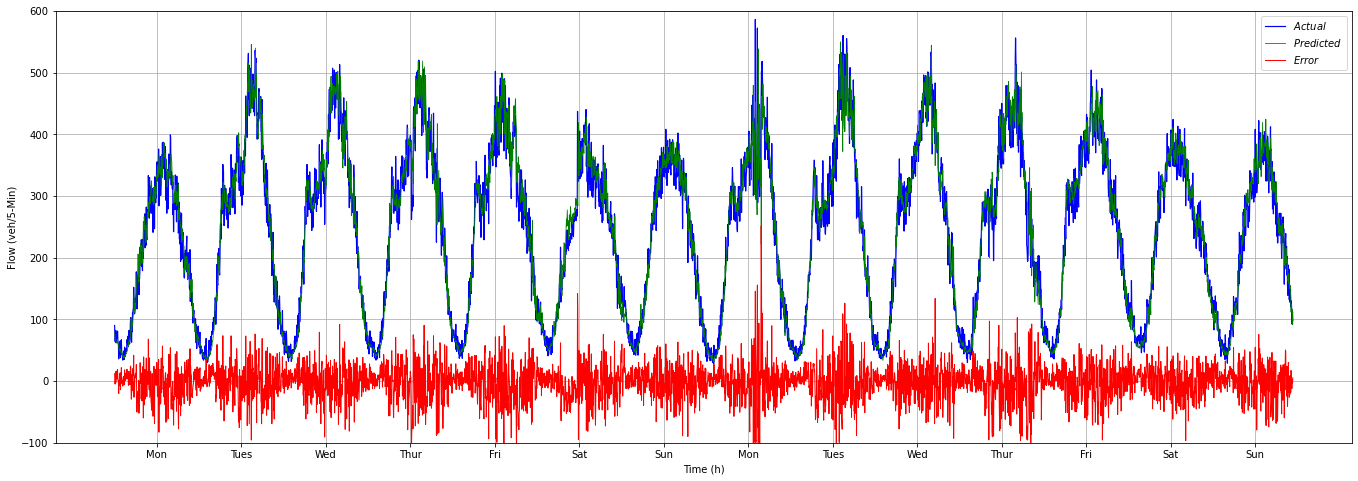

In [37]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv5, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions5, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv5-test_predictions5), lw=1, label=r'$Error$', color='red')

#axes.set_xlim(0,24)
axes.set_ylim(-100,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([144 + i for i in range(0, 4032, 288)])
axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

plt.show()

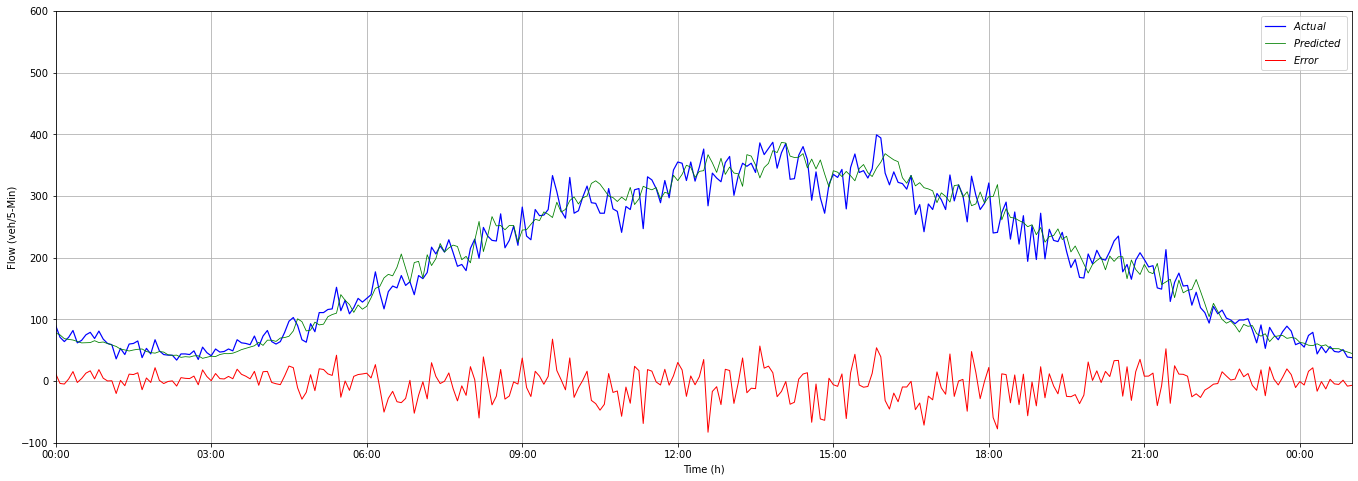

In [38]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv5, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions5, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv5-test_predictions5), lw=1, label=r'$Error$', color='red')

axes.set_xlim(0,300)
axes.set_ylim(-100,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

plt.show()

# 15 mins ahead

In [39]:
def build_model_15(hp):
    # Inputs
    channel_Deep = keras.layers.Input(shape=(None, n_steps, n_features, n_channels), name="DeepInput")
    
    # Deep Model
    # CNN 
    CNN_15 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_15 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_15)
    # LSTM          
    LSTM_15 = keras.layers.LSTM(units=hp.Int("units_LSTM", min_value=1, max_value=100, step=1), 
                                activation='relu')(flatten_15)
        
    # Output
    output = keras.layers.Dense(1, name= "output")(LSTM_15)
    
    # Model
    model_15 = keras.Model(inputs=[channel_Deep], outputs=[output])

    # Compile
    model_15.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_15

In [40]:
tuner15 = RandomSearch(
    build_model_15,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=5,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="7b-CNN-LSTM-15",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\7b-CNN-LSTM-15\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\7b-CNN-LSTM-15\tuner0.json


In [41]:
tuner15.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [42]:
tuner15.search((Xt15), yt15, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop], 
            verbose=2)

INFO:tensorflow:Oracle triggered exit


In [43]:
tuner15.results_summary(1)

Results summary
Results in C:\RunsOak\7b-CNN-LSTM-15
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters: 480
kernel_size: 2
units_LSTM: 30
learning_rate: 0.001
Score: 0.002109687263146043


### Best model

In [44]:
best_hp15 = tuner15.get_best_hyperparameters()[0]
model15 = tuner15.hypermodel.build(best_hp15)

In [45]:
scaler_filename = "Best_HP/7b-ConvLSTM-15"
joblib.dump(best_hp15, scaler_filename) 

['Best_HP/7b-ConvLSTM-15']

In [46]:
model15.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DeepInput (InputLayer)       [(None, None, 5, 6, 1)]   0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 4, 5, 480)   2400      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 9600)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 30)                1155720   
_________________________________________________________________
output (Dense)               (None, 1)                 31        
Total params: 1,158,151
Trainable params: 1,158,151
Non-trainable params: 0
_________________________________________________________________


In [47]:
# model15.fit((Xt15), yt15, 
#             epochs = 100, 
#             verbose = 0)

In [48]:
# metrics15 = pd.DataFrame(model15.history.history)

In [49]:
# metrics15[['loss']].plot()

In [50]:
MSE15  = []
MAE15  = []
RMSE15 = []
MAPE15 = []

for i in range(100):
    print(f"run: {i+1}")
    model15.fit((Xt15), yt15, 
            epochs = 200, validation_split = val_percent,
            callbacks = [stop],
            verbose = 1)
    
    test_predictions15 = model15.predict((Xv15))

    yv15 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
    yv15 = yv15[17:,3]

    df = Test.drop(Test.head(17).index)
    df.reset_index(inplace = True)
    df = df.drop(columns=['index','Timestamp'])
    df['f4'] = pd.Series(test_predictions15.flatten())

    test_predictions15 = scaler.inverse_transform(df)

    test_predictions15 = test_predictions15[:,3]

    MSE15.append(mean_squared_error(yv15,test_predictions15))

    MAE15.append(mean_absolute_error(yv15,test_predictions15))

    RMSE15.append(np.sqrt(mean_squared_error(yv15,test_predictions15)))

    MAPE15.append(mean_absolute_percentage_error(yv15,test_predictions15)*100)

    
    current_mse = mean_squared_error(yv15,test_predictions15)
    if all(i > current_mse for i in MSE15):
        model15.save("my_dir/7b-CNN-LSTM-15")

eval15 = [mean(MSE15), mean(MAE15), mean(RMSE15), mean(MAPE15)]
std15 = [stdev(MSE15), stdev(MAE15), stdev(RMSE15), stdev(MAPE15)]
print(eval15)

run: 1
Epoch 1/200
1423/1423 [==============================] - 29s 20ms/step - loss: 0.0030 - mean_absolute_error: 0.0388 - root_mean_squared_error: 0.0544 - mean_absolute_percentage_error: 1629.9688 - val_loss: 0.0041 - val_mean_absolute_error: 0.0481 - val_root_mean_squared_error: 0.0638 - val_mean_absolute_percentage_error: 13.7810
Epoch 2/200
1423/1423 [==============================] - 29s 21ms/step - loss: 0.0024 - mean_absolute_error: 0.0362 - root_mean_squared_error: 0.0489 - mean_absolute_percentage_error: 1205.9042 - val_loss: 0.0025 - val_mean_absolute_error: 0.0374 - val_root_mean_squared_error: 0.0498 - val_mean_absolute_percentage_error: 11.9679
Epoch 3/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0023 - mean_absolute_error: 0.0356 - root_mean_squared_error: 0.0480 - mean_absolute_percentage_error: 1012.6088 - val_loss: 0.0025 - val_mean_absolute_error: 0.0369 - val_root_mean_squared_error: 0.0498 - val_mean_absolute_percentage_error: 12.4134


Epoch 10/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0020 - mean_absolute_error: 0.0328 - root_mean_squared_error: 0.0444 - mean_absolute_percentage_error: 1271.4331 - val_loss: 0.0021 - val_mean_absolute_error: 0.0342 - val_root_mean_squared_error: 0.0460 - val_mean_absolute_percentage_error: 11.2148
run: 4
Epoch 1/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0020 - mean_absolute_error: 0.0330 - root_mean_squared_error: 0.0446 - mean_absolute_percentage_error: 1038.9119 - val_loss: 0.0021 - val_mean_absolute_error: 0.0344 - val_root_mean_squared_error: 0.0458 - val_mean_absolute_percentage_error: 12.1304
Epoch 2/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0020 - mean_absolute_error: 0.0329 - root_mean_squared_error: 0.0445 - mean_absolute_percentage_error: 1254.4821 - val_loss: 0.0021 - val_mean_absolute_error: 0.0338 - val_root_mean_squared_error: 0.0456 - val_mean_absolute_percentage_error: 11.3816

1423/1423 [==============================] - 31s 22ms/step - loss: 0.0018 - mean_absolute_error: 0.0319 - root_mean_squared_error: 0.0430 - mean_absolute_percentage_error: 1062.3280 - val_loss: 0.0021 - val_mean_absolute_error: 0.0339 - val_root_mean_squared_error: 0.0459 - val_mean_absolute_percentage_error: 11.7067
Epoch 8/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0018 - mean_absolute_error: 0.0318 - root_mean_squared_error: 0.0428 - mean_absolute_percentage_error: 1093.4608 - val_loss: 0.0021 - val_mean_absolute_error: 0.0340 - val_root_mean_squared_error: 0.0459 - val_mean_absolute_percentage_error: 11.5470
Epoch 9/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0018 - mean_absolute_error: 0.0317 - root_mean_squared_error: 0.0428 - mean_absolute_percentage_error: 1046.7366 - val_loss: 0.0022 - val_mean_absolute_error: 0.0350 - val_root_mean_squared_error: 0.0473 - val_mean_absolute_percentage_error: 12.0488
Epoch 10/200
1423/1

1423/1423 [==============================] - 30s 21ms/step - loss: 0.0018 - mean_absolute_error: 0.0312 - root_mean_squared_error: 0.0420 - mean_absolute_percentage_error: 896.2242 - val_loss: 0.0022 - val_mean_absolute_error: 0.0347 - val_root_mean_squared_error: 0.0464 - val_mean_absolute_percentage_error: 11.8846
Epoch 6/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0018 - mean_absolute_error: 0.0312 - root_mean_squared_error: 0.0420 - mean_absolute_percentage_error: 1064.1158 - val_loss: 0.0021 - val_mean_absolute_error: 0.0341 - val_root_mean_squared_error: 0.0459 - val_mean_absolute_percentage_error: 11.3802
Epoch 7/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0017 - mean_absolute_error: 0.0310 - root_mean_squared_error: 0.0417 - mean_absolute_percentage_error: 1084.2719 - val_loss: 0.0023 - val_mean_absolute_error: 0.0356 - val_root_mean_squared_error: 0.0479 - val_mean_absolute_percentage_error: 11.4553
run: 15
Epoch 1/200


Epoch 4/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0017 - mean_absolute_error: 0.0310 - root_mean_squared_error: 0.0417 - mean_absolute_percentage_error: 1123.0414 - val_loss: 0.0021 - val_mean_absolute_error: 0.0343 - val_root_mean_squared_error: 0.0463 - val_mean_absolute_percentage_error: 11.6084
Epoch 5/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0417 - mean_absolute_percentage_error: 901.2661 - val_loss: 0.0021 - val_mean_absolute_error: 0.0343 - val_root_mean_squared_error: 0.0461 - val_mean_absolute_percentage_error: 11.2628
Epoch 6/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0017 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0416 - mean_absolute_percentage_error: 1055.1471 - val_loss: 0.0022 - val_mean_absolute_error: 0.0351 - val_root_mean_squared_error: 0.0471 - val_mean_absolute_percentage_error: 11.3590
run: 19


Epoch 7/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0016 - mean_absolute_error: 0.0302 - root_mean_squared_error: 0.0406 - mean_absolute_percentage_error: 1033.7946 - val_loss: 0.0022 - val_mean_absolute_error: 0.0348 - val_root_mean_squared_error: 0.0469 - val_mean_absolute_percentage_error: 11.6248
Epoch 8/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0016 - mean_absolute_error: 0.0301 - root_mean_squared_error: 0.0405 - mean_absolute_percentage_error: 1085.4191 - val_loss: 0.0023 - val_mean_absolute_error: 0.0350 - val_root_mean_squared_error: 0.0475 - val_mean_absolute_percentage_error: 11.7336
Epoch 9/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0016 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0404 - mean_absolute_percentage_error: 1057.6426 - val_loss: 0.0023 - val_mean_absolute_error: 0.0354 - val_root_mean_squared_error: 0.0480 - val_mean_absolute_percentage_error: 11.4893
run: 25

Epoch 4/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0016 - mean_absolute_error: 0.0298 - root_mean_squared_error: 0.0399 - mean_absolute_percentage_error: 1034.1930 - val_loss: 0.0024 - val_mean_absolute_error: 0.0363 - val_root_mean_squared_error: 0.0490 - val_mean_absolute_percentage_error: 11.7351
Epoch 5/200
1423/1423 [==============================] - 31s 21ms/step - loss: 0.0016 - mean_absolute_error: 0.0297 - root_mean_squared_error: 0.0399 - mean_absolute_percentage_error: 961.7577 - val_loss: 0.0022 - val_mean_absolute_error: 0.0352 - val_root_mean_squared_error: 0.0474 - val_mean_absolute_percentage_error: 12.0037
Epoch 6/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0016 - mean_absolute_error: 0.0296 - root_mean_squared_error: 0.0397 - mean_absolute_percentage_error: 1028.7161 - val_loss: 0.0023 - val_mean_absolute_error: 0.0358 - val_root_mean_squared_error: 0.0484 - val_mean_absolute_percentage_error: 11.7455
Epoch 7/

1423/1423 [==============================] - 31s 21ms/step - loss: 0.0015 - mean_absolute_error: 0.0288 - root_mean_squared_error: 0.0386 - mean_absolute_percentage_error: 1034.7537 - val_loss: 0.0024 - val_mean_absolute_error: 0.0360 - val_root_mean_squared_error: 0.0490 - val_mean_absolute_percentage_error: 12.1607 mean_absolute_error: 0.0287 - root_mean_squared_error: 0.0385 - mean_ab
run: 33
Epoch 1/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0015 - mean_absolute_error: 0.0290 - root_mean_squared_error: 0.0389 - mean_absolute_percentage_error: 1042.1523 - val_loss: 0.0024 - val_mean_absolute_error: 0.0359 - val_root_mean_squared_error: 0.0490 - val_mean_absolute_percentage_error: 11.6867
Epoch 2/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0015 - mean_absolute_error: 0.0290 - root_mean_squared_error: 0.0389 - mean_absolute_percentage_error: 1111.5674 - val_loss: 0.0024 - val_mean_absolute_error: 0.0359 - val_root_mean_squared

Epoch 6/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0014 - mean_absolute_error: 0.0282 - root_mean_squared_error: 0.0378 - mean_absolute_percentage_error: 948.4727 - val_loss: 0.0025 - val_mean_absolute_error: 0.0369 - val_root_mean_squared_error: 0.0502 - val_mean_absolute_percentage_error: 12.1933
Epoch 7/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0014 - mean_absolute_error: 0.0282 - root_mean_squared_error: 0.0378 - mean_absolute_percentage_error: 1037.3381 - val_loss: 0.0024 - val_mean_absolute_error: 0.0364 - val_root_mean_squared_error: 0.0494 - val_mean_absolute_percentage_error: 11.9205
run: 39
Epoch 1/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0014 - mean_absolute_error: 0.0283 - root_mean_squared_error: 0.0379 - mean_absolute_percentage_error: 1099.9666 - val_loss: 0.0025 - val_mean_absolute_error: 0.0367 - val_root_mean_squared_error: 0.0499 - val_mean_absolute_percentage_error: 12.0945


Epoch 3/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0014 - mean_absolute_error: 0.0276 - root_mean_squared_error: 0.0370 - mean_absolute_percentage_error: 861.1500 - val_loss: 0.0026 - val_mean_absolute_error: 0.0370 - val_root_mean_squared_error: 0.0508 - val_mean_absolute_percentage_error: 11.9505
Epoch 4/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0014 - mean_absolute_error: 0.0275 - root_mean_squared_error: 0.0368 - mean_absolute_percentage_error: 769.9188 - val_loss: 0.0026 - val_mean_absolute_error: 0.0373 - val_root_mean_squared_error: 0.0509 - val_mean_absolute_percentage_error: 11.9967
Epoch 5/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0014 - mean_absolute_error: 0.0275 - root_mean_squared_error: 0.0368 - mean_absolute_percentage_error: 917.1306 - val_loss: 0.0026 - val_mean_absolute_error: 0.0375 - val_root_mean_squared_error: 0.0513 - val_mean_absolute_percentage_error: 12.5276
Epoch 6/20

1423/1423 [==============================] - 31s 22ms/step - loss: 0.0013 - mean_absolute_error: 0.0269 - root_mean_squared_error: 0.0360 - mean_absolute_percentage_error: 1001.4227 - val_loss: 0.0027 - val_mean_absolute_error: 0.0381 - val_root_mean_squared_error: 0.0522 - val_mean_absolute_percentage_error: 13.2169
Epoch 8/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0013 - mean_absolute_error: 0.0269 - root_mean_squared_error: 0.0359 - mean_absolute_percentage_error: 993.7162 - val_loss: 0.0028 - val_mean_absolute_error: 0.0383 - val_root_mean_squared_error: 0.0527 - val_mean_absolute_percentage_error: 12.8787
run: 51
Epoch 1/200
1423/1423 [==============================] - 31s 21ms/step - loss: 0.0013 - mean_absolute_error: 0.0270 - root_mean_squared_error: 0.0361 - mean_absolute_percentage_error: 982.0131 - val_loss: 0.0026 - val_mean_absolute_error: 0.0372 - val_root_mean_squared_error: 0.0512 - val_mean_absolute_percentage_error: 12.3364
Epoch 2/200
1

Epoch 2/200
1423/1423 [==============================] - 31s 21ms/step - loss: 0.0013 - mean_absolute_error: 0.0265 - root_mean_squared_error: 0.0355 - mean_absolute_percentage_error: 883.8509 - val_loss: 0.0027 - val_mean_absolute_error: 0.0377 - val_root_mean_squared_error: 0.0519 - val_mean_absolute_percentage_error: 12.1389
Epoch 3/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0013 - mean_absolute_error: 0.0265 - root_mean_squared_error: 0.0355 - mean_absolute_percentage_error: 1001.3815 - val_loss: 0.0027 - val_mean_absolute_error: 0.0377 - val_root_mean_squared_error: 0.0519 - val_mean_absolute_percentage_error: 12.2511
Epoch 4/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0012 - mean_absolute_error: 0.0264 - root_mean_squared_error: 0.0354 - mean_absolute_percentage_error: 1071.3242 - val_loss: 0.0027 - val_mean_absolute_error: 0.0376 - val_root_mean_squared_error: 0.0518 - val_mean_absolute_percentage_error: 12.4028
Epoch 5/

Epoch 8/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0012 - mean_absolute_error: 0.0261 - root_mean_squared_error: 0.0348 - mean_absolute_percentage_error: 1065.9873 - val_loss: 0.0028 - val_mean_absolute_error: 0.0381 - val_root_mean_squared_error: 0.0527 - val_mean_absolute_percentage_error: 12.4031
run: 56
Epoch 1/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0012 - mean_absolute_error: 0.0262 - root_mean_squared_error: 0.0350 - mean_absolute_percentage_error: 830.6852 - val_loss: 0.0028 - val_mean_absolute_error: 0.0384 - val_root_mean_squared_error: 0.0530 - val_mean_absolute_percentage_error: 12.3679
Epoch 2/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0012 - mean_absolute_error: 0.0262 - root_mean_squared_error: 0.0349 - mean_absolute_percentage_error: 1105.5586 - val_loss: 0.0028 - val_mean_absolute_error: 0.0385 - val_root_mean_squared_error: 0.0528 - val_mean_absolute_percentage_error: 12.2569


Epoch 2/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0012 - mean_absolute_error: 0.0259 - root_mean_squared_error: 0.0346 - mean_absolute_percentage_error: 977.3060 - val_loss: 0.0028 - val_mean_absolute_error: 0.0384 - val_root_mean_squared_error: 0.0527 - val_mean_absolute_percentage_error: 13.0007
Epoch 3/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0012 - mean_absolute_error: 0.0259 - root_mean_squared_error: 0.0345 - mean_absolute_percentage_error: 947.0049 - val_loss: 0.0028 - val_mean_absolute_error: 0.0387 - val_root_mean_squared_error: 0.0534 - val_mean_absolute_percentage_error: 13.0389
Epoch 4/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0012 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0345 - mean_absolute_percentage_error: 944.8499 - val_loss: 0.0027 - val_mean_absolute_error: 0.0380 - val_root_mean_squared_error: 0.0524 - val_mean_absolute_percentage_error: 12.3713
Epoch 5/20

1423/1423 [==============================] - 30s 21ms/step - loss: 0.0011 - mean_absolute_error: 0.0253 - root_mean_squared_error: 0.0337 - mean_absolute_percentage_error: 976.9270 - val_loss: 0.0029 - val_mean_absolute_error: 0.0385 - val_root_mean_squared_error: 0.0535 - val_mean_absolute_percentage_error: 12.3878
Epoch 3/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0011 - mean_absolute_error: 0.0254 - root_mean_squared_error: 0.0338 - mean_absolute_percentage_error: 982.1628 - val_loss: 0.0029 - val_mean_absolute_error: 0.0392 - val_root_mean_squared_error: 0.0541 - val_mean_absolute_percentage_error: 12.4935
Epoch 4/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0011 - mean_absolute_error: 0.0253 - root_mean_squared_error: 0.0337 - mean_absolute_percentage_error: 1109.0493 - val_loss: 0.0030 - val_mean_absolute_error: 0.0396 - val_root_mean_squared_error: 0.0552 - val_mean_absolute_percentage_error: 13.3061
Epoch 5/200
1423/1423

Epoch 7/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0011 - mean_absolute_error: 0.0251 - root_mean_squared_error: 0.0335 - mean_absolute_percentage_error: 954.9033 - val_loss: 0.0031 - val_mean_absolute_error: 0.0395 - val_root_mean_squared_error: 0.0554 - val_mean_absolute_percentage_error: 12.8245
Epoch 8/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0011 - mean_absolute_error: 0.0251 - root_mean_squared_error: 0.0334 - mean_absolute_percentage_error: 919.4677 - val_loss: 0.0030 - val_mean_absolute_error: 0.0390 - val_root_mean_squared_error: 0.0545 - val_mean_absolute_percentage_error: 12.9037
Epoch 9/200
1423/1423 [==============================] - 31s 21ms/step - loss: 0.0011 - mean_absolute_error: 0.0250 - root_mean_squared_error: 0.0333 - mean_absolute_percentage_error: 1079.0646 - val_loss: 0.0030 - val_mean_absolute_error: 0.0395 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_percentage_error: 12.6666
run: 69
E

Epoch 3/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0011 - mean_absolute_error: 0.0248 - root_mean_squared_error: 0.0330 - mean_absolute_percentage_error: 850.9379 - val_loss: 0.0030 - val_mean_absolute_error: 0.0390 - val_root_mean_squared_error: 0.0547 - val_mean_absolute_percentage_error: 12.4879
Epoch 4/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0011 - mean_absolute_error: 0.0248 - root_mean_squared_error: 0.0330 - mean_absolute_percentage_error: 1026.8907 - val_loss: 0.0031 - val_mean_absolute_error: 0.0395 - val_root_mean_squared_error: 0.0555 - val_mean_absolute_percentage_error: 12.6344
Epoch 5/200
1423/1423 [==============================] - 30s 21ms/step - loss: 0.0011 - mean_absolute_error: 0.0247 - root_mean_squared_error: 0.0329 - mean_absolute_percentage_error: 986.7932 - val_loss: 0.0030 - val_mean_absolute_error: 0.0393 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_percentage_error: 12.4858
Epoch 6/2

1423/1423 [==============================] - 31s 22ms/step - loss: 0.0011 - mean_absolute_error: 0.0244 - root_mean_squared_error: 0.0325 - mean_absolute_percentage_error: 1072.5171 - val_loss: 0.0031 - val_mean_absolute_error: 0.0395 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_percentage_error: 12.8376
Epoch 2/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0011 - mean_absolute_error: 0.0244 - root_mean_squared_error: 0.0325 - mean_absolute_percentage_error: 812.8906 - val_loss: 0.0031 - val_mean_absolute_error: 0.0400 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_percentage_error: 12.8159
Epoch 3/200
1423/1423 [==============================] - 31s 22ms/step - loss: 0.0010 - mean_absolute_error: 0.0243 - root_mean_squared_error: 0.0323 - mean_absolute_percentage_error: 984.4101 - val_loss: 0.0032 - val_mean_absolute_error: 0.0403 - val_root_mean_squared_error: 0.0568 - val_mean_absolute_percentage_error: 12.9097
Epoch 4/200
1423/1423

run: 81
Epoch 1/200
1423/1423 [==============================] - 30s 21ms/step - loss: 9.9156e-04 - mean_absolute_error: 0.0236 - root_mean_squared_error: 0.0315 - mean_absolute_percentage_error: 896.0809 - val_loss: 0.0032 - val_mean_absolute_error: 0.0402 - val_root_mean_squared_error: 0.0566 - val_mean_absolute_percentage_error: 12.7947
Epoch 2/200
1423/1423 [==============================] - 30s 21ms/step - loss: 9.9082e-04 - mean_absolute_error: 0.0236 - root_mean_squared_error: 0.0315 - mean_absolute_percentage_error: 962.1409 - val_loss: 0.0032 - val_mean_absolute_error: 0.0401 - val_root_mean_squared_error: 0.0562 - val_mean_absolute_percentage_error: 12.9857
Epoch 3/200
1423/1423 [==============================] - 30s 21ms/step - loss: 9.8761e-04 - mean_absolute_error: 0.0237 - root_mean_squared_error: 0.0314 - mean_absolute_percentage_error: 962.8961 - val_loss: 0.0031 - val_mean_absolute_error: 0.0398 - val_root_mean_squared_error: 0.0558 - val_mean_absolute_percentage_error

1423/1423 [==============================] - 30s 21ms/step - loss: 9.5162e-04 - mean_absolute_error: 0.0232 - root_mean_squared_error: 0.0308 - mean_absolute_percentage_error: 1062.6780 - val_loss: 0.0032 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0570 - val_mean_absolute_percentage_error: 13.1277
Epoch 6/200
1423/1423 [==============================] - 30s 21ms/step - loss: 9.5660e-04 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0309 - mean_absolute_percentage_error: 888.7562 - val_loss: 0.0034 - val_mean_absolute_error: 0.0412 - val_root_mean_squared_error: 0.0579 - val_mean_absolute_percentage_error: 13.2949
Epoch 7/200
1423/1423 [==============================] - 30s 21ms/step - loss: 9.5263e-04 - mean_absolute_error: 0.0232 - root_mean_squared_error: 0.0309 - mean_absolute_percentage_error: 827.1100 - val_loss: 0.0035 - val_mean_absolute_error: 0.0416 - val_root_mean_squared_error: 0.0590 - val_mean_absolute_percentage_error: 14.0042
Epoch 8/2

1423/1423 [==============================] - 30s 21ms/step - loss: 9.1025e-04 - mean_absolute_error: 0.0227 - root_mean_squared_error: 0.0302 - mean_absolute_percentage_error: 891.4769 - val_loss: 0.0032 - val_mean_absolute_error: 0.0405 - val_root_mean_squared_error: 0.0566 - val_mean_absolute_percentage_error: 12.8544
Epoch 7/200
1423/1423 [==============================] - 30s 21ms/step - loss: 9.0257e-04 - mean_absolute_error: 0.0226 - root_mean_squared_error: 0.0300 - mean_absolute_percentage_error: 994.0388 - val_loss: 0.0035 - val_mean_absolute_error: 0.0422 - val_root_mean_squared_error: 0.0594 - val_mean_absolute_percentage_error: 13.5463
Epoch 8/200
1423/1423 [==============================] - 30s 21ms/step - loss: 9.0568e-04 - mean_absolute_error: 0.0227 - root_mean_squared_error: 0.0301 - mean_absolute_percentage_error: 938.3797 - val_loss: 0.0033 - val_mean_absolute_error: 0.0409 - val_root_mean_squared_error: 0.0574 - val_mean_absolute_percentage_error: 12.9979
Epoch 9/20

1423/1423 [==============================] - 31s 22ms/step - loss: 8.7937e-04 - mean_absolute_error: 0.0223 - root_mean_squared_error: 0.0297 - mean_absolute_percentage_error: 824.3265 - val_loss: 0.0034 - val_mean_absolute_error: 0.0417 - val_root_mean_squared_error: 0.0583 - val_mean_absolute_percentage_error: 12.9999
Epoch 3/200
1423/1423 [==============================] - 30s 21ms/step - loss: 8.8081e-04 - mean_absolute_error: 0.0224 - root_mean_squared_error: 0.0297 - mean_absolute_percentage_error: 1059.3480 - val_loss: 0.0034 - val_mean_absolute_error: 0.0416 - val_root_mean_squared_error: 0.0584 - val_mean_absolute_percentage_error: 13.1197
Epoch 4/200
1423/1423 [==============================] - 31s 22ms/step - loss: 8.8007e-04 - mean_absolute_error: 0.0223 - root_mean_squared_error: 0.0297 - mean_absolute_percentage_error: 904.4551 - val_loss: 0.0033 - val_mean_absolute_error: 0.0412 - val_root_mean_squared_error: 0.0575 - val_mean_absolute_percentage_error: 13.1161
Epoch 5/2

In [51]:
model15 = keras.models.load_model("my_dir/7b-CNN-LSTM-15")

In [102]:
runs = {'MSE': MSE15, 'MAE': MAE15, 'RMSE': RMSE15, 'MAPE': MAPE15}
table15 = pd.DataFrame(data=runs)
table15.to_csv("Results/Runs/7b-CNN-LSTM-15")

In [103]:
pd.read_csv("Results/Runs/7b-CNN-LSTM-15", index_col=0)

,MSE,MAE,RMSE,MAPE
0,876.883039,21.825426,29.612211,10.663018
1,878.417958,21.792549,29.638117,10.653081
2,880.529411,21.875792,29.673716,10.596550
3,880.169585,21.872647,29.667652,11.028095
4,900.872168,22.114250,30.014533,10.725737
...,...,...,...,...
95,1417.100065,26.455225,37.644390,12.685286
96,1379.126338,26.126626,37.136590,12.216256
97,1396.861098,26.487321,37.374605,12.739592
98,1355.702715,25.977641,36.819868,12.214463


### Evaluation on inverse_transform

In [52]:
test_predictions15 = model15.predict(Xv15)

yv15 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv15 = yv15[17:,3]

df = Test.drop(Test.head(17).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f4'] = pd.Series(test_predictions15.flatten())

test_predictions15 = scaler.inverse_transform(df)

test_predictions15 = test_predictions15[:,3]

# MSE15 = mean_squared_error(yv15,test_predictions15)

# MAE15 = mean_absolute_error(yv15,test_predictions15)

# RMSE15 = np.sqrt(MSE15)

# MAPE15 = mean_absolute_percentage_error(yv15,test_predictions15)*100

# eval15 = [MSE15, MAE15, RMSE15, MAPE15]
# print(eval15)

In [53]:
RA10 = ra.RA_10(np.asarray(yv15), np.asarray(test_predictions15))
RA15 = ra.RA_15(np.asarray(yv15), np.asarray(test_predictions15))
RA20 = ra.RA_20(np.asarray(yv15), np.asarray(test_predictions15))

res15 = [RA10, RA15, RA20]
print(res15)

[57.13574097135741, 75.91531755915317, 85.55417185554171]


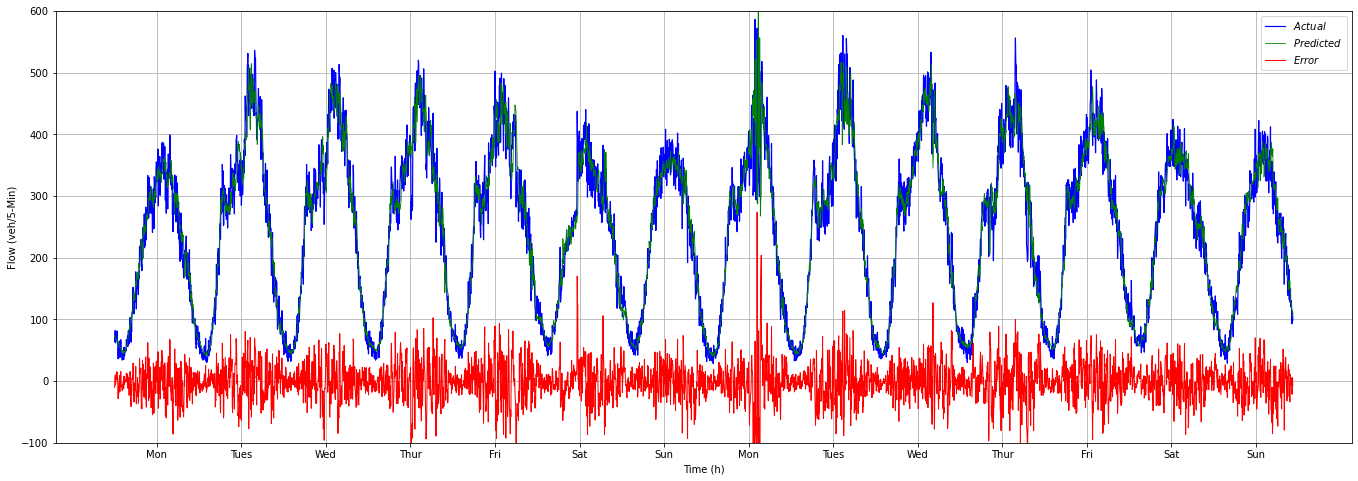

In [54]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv15, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions15, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv15-test_predictions15), lw=1, label=r'$Error$', color='red')

#axes.set_xlim(0,24)
axes.set_ylim(-100,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([144 + i for i in range(0, 4032, 288)])
axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

plt.show()

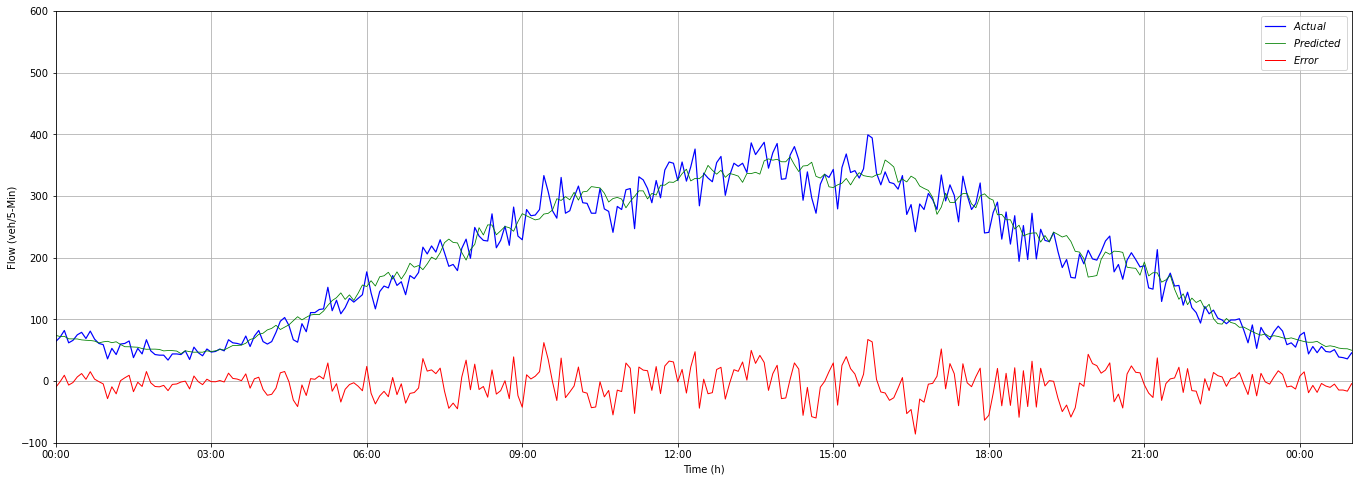

In [55]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv15, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions15, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv15-test_predictions15), lw=1, label=r'$Error$', color='red')

axes.set_xlim(0,300)
axes.set_ylim(-100,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

plt.show()

# 30 mins ahead

In [56]:
def build_model_30(hp):
    # Input
    channel_Deep = keras.layers.Input(shape=(None, n_steps, n_features, n_channels), name="DeepInput")
    
    # Deep Model
    # CNN 
    CNN_30 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_30 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_30)
    # LSTM          
    LSTM_30 = keras.layers.LSTM(units=hp.Int("units_LSTM", min_value=1, max_value=100, step=1), 
                                activation='relu')(flatten_30)
    
    # Output
    output = keras.layers.Dense(1, name= "output")(LSTM_30)
    
    # Model
    model_30 = keras.Model(inputs=[channel_Deep], outputs=[output])

    # Compile
    model_30.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_30

In [57]:
tuner30 = RandomSearch(
    build_model_30,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=5,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="7b-CNN-LSTM-30",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\7b-CNN-LSTM-30\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\7b-CNN-LSTM-30\tuner0.json


In [58]:
tuner30.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [59]:
tuner30.search((Xt30), yt30, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

INFO:tensorflow:Oracle triggered exit


In [60]:
tuner30.results_summary(1)

Results summary
Results in C:\RunsOak\7b-CNN-LSTM-30
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters: 352
kernel_size: 2
units_LSTM: 73
learning_rate: 0.0001
Score: 0.002272584056481719


### Best model

In [61]:
best_hp30 = tuner30.get_best_hyperparameters()[0]
model30 = tuner30.hypermodel.build(best_hp30)

In [62]:
scaler_filename = "7b-ConvLSTM-30"
joblib.dump(best_hp30, scaler_filename) 

['7b-ConvLSTM-30']

In [63]:
model30.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DeepInput (InputLayer)       [(None, None, 5, 6, 1)]   0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 4, 5, 352)   1760      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 7040)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 73)                2077288   
_________________________________________________________________
output (Dense)               (None, 1)                 74        
Total params: 2,079,122
Trainable params: 2,079,122
Non-trainable params: 0
_________________________________________________________________


In [64]:
# model30.fit(Xt30, yt30, 
#             epochs = 100, 
#             verbose = 0)

In [65]:
# model30.save("my_dir/7b-CNN-LSTM-30")

In [66]:
# metrics30 = pd.DataFrame(model30.history.history)

In [67]:
# metrics30[['loss']].plot()

In [68]:
MSE30  = []
MAE30  = []
RMSE30 = []
MAPE30 = []

for i in range(100):
    print(f"run: {i+1}")
    model30.fit((Xt30), yt30, 
            epochs = 200, validation_split = val_percent,
            callbacks = [stop],
            verbose = 1)
    
    test_predictions30 = model30.predict((Xv30))

    yv30 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
    yv30 = yv30[20:,3]

    df = Test.drop(Test.head(20).index)
    df.reset_index(inplace = True)
    df = df.drop(columns=['index','Timestamp'])
    df['f4'] = pd.Series(test_predictions30.flatten())

    test_predictions30 = scaler.inverse_transform(df)

    test_predictions30 = test_predictions30[:,3]

    MSE30.append(mean_squared_error(yv30,test_predictions30))

    MAE30.append(mean_absolute_error(yv30,test_predictions30))

    RMSE30.append(np.sqrt(mean_squared_error(yv30,test_predictions30)))

    MAPE30.append(mean_absolute_percentage_error(yv30,test_predictions30)*100)

    
    current_mse = mean_squared_error(yv30,test_predictions30)
    if all(i > current_mse for i in MSE30):
        model30.save("my_dir/7d-CNN-LSTM-30")

eval30 = [mean(MSE30), mean(MAE30), mean(RMSE30), mean(MAPE30)]
std30 = [stdev(MSE30), stdev(MAE30), stdev(RMSE30), stdev(MAPE30)]
print(eval30)

run: 1
Epoch 1/200
1422/1422 [==============================] - 40s 28ms/step - loss: 0.0040 - mean_absolute_error: 0.0444 - root_mean_squared_error: 0.0632 - mean_absolute_percentage_error: 1005.3180 - val_loss: 0.0029 - val_mean_absolute_error: 0.0401 - val_root_mean_squared_error: 0.0537 - val_mean_absolute_percentage_error: 14.7143
Epoch 2/200
1422/1422 [==============================] - 40s 28ms/step - loss: 0.0027 - mean_absolute_error: 0.0386 - root_mean_squared_error: 0.0520 - mean_absolute_percentage_error: 1496.6740 - val_loss: 0.0029 - val_mean_absolute_error: 0.0406 - val_root_mean_squared_error: 0.0542 - val_mean_absolute_percentage_error: 12.6418
Epoch 3/200
1422/1422 [==============================] - 40s 28ms/step - loss: 0.0027 - mean_absolute_error: 0.0381 - root_mean_squared_error: 0.0515 - mean_absolute_percentage_error: 1272.6877 - val_loss: 0.0027 - val_mean_absolute_error: 0.0388 - val_root_mean_squared_error: 0.0520 - val_mean_absolute_percentage_error: 12.9122


Epoch 2/200
1422/1422 [==============================] - 40s 28ms/step - loss: 0.0023 - mean_absolute_error: 0.0355 - root_mean_squared_error: 0.0480 - mean_absolute_percentage_error: 1563.4850 - val_loss: 0.0025 - val_mean_absolute_error: 0.0369 - val_root_mean_squared_error: 0.0497 - val_mean_absolute_percentage_error: 13.3998
Epoch 3/200
1422/1422 [==============================] - 40s 28ms/step - loss: 0.0023 - mean_absolute_error: 0.0355 - root_mean_squared_error: 0.0480 - mean_absolute_percentage_error: 1502.8536 - val_loss: 0.0024 - val_mean_absolute_error: 0.0366 - val_root_mean_squared_error: 0.0494 - val_mean_absolute_percentage_error: 12.0163
Epoch 4/200
1422/1422 [==============================] - 40s 28ms/step - loss: 0.0023 - mean_absolute_error: 0.0354 - root_mean_squared_error: 0.0479 - mean_absolute_percentage_error: 1435.5732 - val_loss: 0.0023 - val_mean_absolute_error: 0.0356 - val_root_mean_squared_error: 0.0482 - val_mean_absolute_percentage_error: 12.1280
Epoch 5

Epoch 6/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0022 - mean_absolute_error: 0.0347 - root_mean_squared_error: 0.0469 - mean_absolute_percentage_error: 1439.0066 - val_loss: 0.0024 - val_mean_absolute_error: 0.0363 - val_root_mean_squared_error: 0.0489 - val_mean_absolute_percentage_error: 12.0829
Epoch 7/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0022 - mean_absolute_error: 0.0347 - root_mean_squared_error: 0.0468 - mean_absolute_percentage_error: 1362.5609 - val_loss: 0.0023 - val_mean_absolute_error: 0.0354 - val_root_mean_squared_error: 0.0481 - val_mean_absolute_percentage_error: 11.7565
Epoch 8/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0022 - mean_absolute_error: 0.0347 - root_mean_squared_error: 0.0469 - mean_absolute_percentage_error: 1424.2411 - val_loss: 0.0023 - val_mean_absolute_error: 0.0355 - val_root_mean_squared_error: 0.0482 - val_mean_absolute_percentage_error: 11.5784
Epoch 9

1422/1422 [==============================] - 41s 29ms/step - loss: 0.0021 - mean_absolute_error: 0.0337 - root_mean_squared_error: 0.0456 - mean_absolute_percentage_error: 1541.8521 - val_loss: 0.0023 - val_mean_absolute_error: 0.0359 - val_root_mean_squared_error: 0.0483 - val_mean_absolute_percentage_error: 13.0451
Epoch 7/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0021 - mean_absolute_error: 0.0338 - root_mean_squared_error: 0.0456 - mean_absolute_percentage_error: 1278.5022 - val_loss: 0.0024 - val_mean_absolute_error: 0.0360 - val_root_mean_squared_error: 0.0487 - val_mean_absolute_percentage_error: 12.0075
Epoch 8/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0021 - mean_absolute_error: 0.0337 - root_mean_squared_error: 0.0455 - mean_absolute_percentage_error: 1337.1366 - val_loss: 0.0023 - val_mean_absolute_error: 0.0353 - val_root_mean_squared_error: 0.0477 - val_mean_absolute_percentage_error: 12.1688
run: 10
Epoch 1/200

Epoch 4/200
1422/1422 [==============================] - 42s 30ms/step - loss: 0.0020 - mean_absolute_error: 0.0333 - root_mean_squared_error: 0.0450 - mean_absolute_percentage_error: 1335.8204 - val_loss: 0.0023 - val_mean_absolute_error: 0.0355 - val_root_mean_squared_error: 0.0481 - val_mean_absolute_percentage_error: 11.7068
Epoch 5/200
1422/1422 [==============================] - 42s 30ms/step - loss: 0.0020 - mean_absolute_error: 0.0333 - root_mean_squared_error: 0.0450 - mean_absolute_percentage_error: 1265.0039 - val_loss: 0.0023 - val_mean_absolute_error: 0.0357 - val_root_mean_squared_error: 0.0483 - val_mean_absolute_percentage_error: 11.9086
Epoch 6/200
1422/1422 [==============================] - 42s 30ms/step - loss: 0.0020 - mean_absolute_error: 0.0333 - root_mean_squared_error: 0.0449 - mean_absolute_percentage_error: 1453.5088 - val_loss: 0.0023 - val_mean_absolute_error: 0.0351 - val_root_mean_squared_error: 0.0474 - val_mean_absolute_percentage_error: 11.8052
Epoch 7

Epoch 11/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0019 - mean_absolute_error: 0.0327 - root_mean_squared_error: 0.0441 - mean_absolute_percentage_error: 1278.6282 - val_loss: 0.0023 - val_mean_absolute_error: 0.0355 - val_root_mean_squared_error: 0.0480 - val_mean_absolute_percentage_error: 11.6007
Epoch 12/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0019 - mean_absolute_error: 0.0327 - root_mean_squared_error: 0.0441 - mean_absolute_percentage_error: 1434.8756 - val_loss: 0.0023 - val_mean_absolute_error: 0.0355 - val_root_mean_squared_error: 0.0480 - val_mean_absolute_percentage_error: 11.9577
run: 15
Epoch 1/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0020 - mean_absolute_error: 0.0329 - root_mean_squared_error: 0.0443 - mean_absolute_percentage_error: 1448.9594 - val_loss: 0.0023 - val_mean_absolute_error: 0.0355 - val_root_mean_squared_error: 0.0480 - val_mean_absolute_percentage_error: 11.74

Epoch 9/200
1422/1422 [==============================] - 40s 28ms/step - loss: 0.0019 - mean_absolute_error: 0.0323 - root_mean_squared_error: 0.0435 - mean_absolute_percentage_error: 1333.8954 - val_loss: 0.0023 - val_mean_absolute_error: 0.0356 - val_root_mean_squared_error: 0.0481 - val_mean_absolute_percentage_error: 12.0359
Epoch 10/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0019 - mean_absolute_error: 0.0323 - root_mean_squared_error: 0.0435 - mean_absolute_percentage_error: 1261.4816 - val_loss: 0.0023 - val_mean_absolute_error: 0.0358 - val_root_mean_squared_error: 0.0481 - val_mean_absolute_percentage_error: 12.1492
Epoch 11/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0019 - mean_absolute_error: 0.0323 - root_mean_squared_error: 0.0435 - mean_absolute_percentage_error: 1330.0378 - val_loss: 0.0023 - val_mean_absolute_error: 0.0355 - val_root_mean_squared_error: 0.0478 - val_mean_absolute_percentage_error: 11.6649
run: 

Epoch 5/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0018 - mean_absolute_error: 0.0318 - root_mean_squared_error: 0.0428 - mean_absolute_percentage_error: 1550.7856 - val_loss: 0.0024 - val_mean_absolute_error: 0.0360 - val_root_mean_squared_error: 0.0486 - val_mean_absolute_percentage_error: 11.7532
Epoch 6/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0018 - mean_absolute_error: 0.0318 - root_mean_squared_error: 0.0427 - mean_absolute_percentage_error: 1468.7279 - val_loss: 0.0023 - val_mean_absolute_error: 0.0359 - val_root_mean_squared_error: 0.0483 - val_mean_absolute_percentage_error: 12.2729
run: 21
Epoch 1/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0019 - mean_absolute_error: 0.0320 - root_mean_squared_error: 0.0430 - mean_absolute_percentage_error: 1361.3079 - val_loss: 0.0023 - val_mean_absolute_error: 0.0355 - val_root_mean_squared_error: 0.0482 - val_mean_absolute_percentage_error: 11.8939

Epoch 5/200
1422/1422 [==============================] - 42s 29ms/step - loss: 0.0018 - mean_absolute_error: 0.0314 - root_mean_squared_error: 0.0422 - mean_absolute_percentage_error: 1425.6229 - val_loss: 0.0023 - val_mean_absolute_error: 0.0358 - val_root_mean_squared_error: 0.0482 - val_mean_absolute_percentage_error: 11.7138
Epoch 6/200
1422/1422 [==============================] - 42s 30ms/step - loss: 0.0018 - mean_absolute_error: 0.0313 - root_mean_squared_error: 0.0421 - mean_absolute_percentage_error: 1301.6106 - val_loss: 0.0024 - val_mean_absolute_error: 0.0359 - val_root_mean_squared_error: 0.0486 - val_mean_absolute_percentage_error: 12.1358
Epoch 7/200
1422/1422 [==============================] - 42s 30ms/step - loss: 0.0018 - mean_absolute_error: 0.0313 - root_mean_squared_error: 0.0421 - mean_absolute_percentage_error: 1395.7383 - val_loss: 0.0024 - val_mean_absolute_error: 0.0360 - val_root_mean_squared_error: 0.0486 - val_mean_absolute_percentage_error: 11.9590
Epoch 8

Epoch 3/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0017 - mean_absolute_error: 0.0308 - root_mean_squared_error: 0.0415 - mean_absolute_percentage_error: 1379.5865 - val_loss: 0.0024 - val_mean_absolute_error: 0.0361 - val_root_mean_squared_error: 0.0490 - val_mean_absolute_percentage_error: 12.0781
Epoch 4/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0017 - mean_absolute_error: 0.0308 - root_mean_squared_error: 0.0414 - mean_absolute_percentage_error: 1446.0431 - val_loss: 0.0024 - val_mean_absolute_error: 0.0362 - val_root_mean_squared_error: 0.0488 - val_mean_absolute_percentage_error: 12.0914
Epoch 5/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0017 - mean_absolute_error: 0.0307 - root_mean_squared_error: 0.0414 - mean_absolute_percentage_error: 1422.3055 - val_loss: 0.0025 - val_mean_absolute_error: 0.0367 - val_root_mean_squared_error: 0.0495 - val_mean_absolute_percentage_error: 12.2107
Epoch 6

Epoch 12/200
1422/1422 [==============================] - 42s 29ms/step - loss: 0.0016 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0404 - mean_absolute_percentage_error: 1393.4423 - val_loss: 0.0026 - val_mean_absolute_error: 0.0378 - val_root_mean_squared_error: 0.0507 - val_mean_absolute_percentage_error: 12.1119
run: 29
Epoch 1/200
1422/1422 [==============================] - 42s 29ms/step - loss: 0.0016 - mean_absolute_error: 0.0302 - root_mean_squared_error: 0.0406 - mean_absolute_percentage_error: 1404.4038 - val_loss: 0.0025 - val_mean_absolute_error: 0.0369 - val_root_mean_squared_error: 0.0498 - val_mean_absolute_percentage_error: 11.9748
Epoch 2/200
1422/1422 [==============================] - 42s 29ms/step - loss: 0.0017 - mean_absolute_error: 0.0302 - root_mean_squared_error: 0.0407 - mean_absolute_percentage_error: 1356.6659 - val_loss: 0.0026 - val_mean_absolute_error: 0.0381 - val_root_mean_squared_error: 0.0514 - val_mean_absolute_percentage_error: 12.203

Epoch 4/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0015 - mean_absolute_error: 0.0291 - root_mean_squared_error: 0.0390 - mean_absolute_percentage_error: 1342.3196 - val_loss: 0.0026 - val_mean_absolute_error: 0.0377 - val_root_mean_squared_error: 0.0511 - val_mean_absolute_percentage_error: 12.3291
Epoch 5/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0015 - mean_absolute_error: 0.0290 - root_mean_squared_error: 0.0389 - mean_absolute_percentage_error: 1470.2725 - val_loss: 0.0025 - val_mean_absolute_error: 0.0370 - val_root_mean_squared_error: 0.0503 - val_mean_absolute_percentage_error: 12.2335
Epoch 6/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0015 - mean_absolute_error: 0.0290 - root_mean_squared_error: 0.0389 - mean_absolute_percentage_error: 1343.7599 - val_loss: 0.0025 - val_mean_absolute_error: 0.0369 - val_root_mean_squared_error: 0.0500 - val_mean_absolute_percentage_error: 12.4947
Epoch 7

Epoch 6/200
1422/1422 [==============================] - 42s 29ms/step - loss: 0.0014 - mean_absolute_error: 0.0277 - root_mean_squared_error: 0.0371 - mean_absolute_percentage_error: 1355.9543 - val_loss: 0.0026 - val_mean_absolute_error: 0.0377 - val_root_mean_squared_error: 0.0510 - val_mean_absolute_percentage_error: 12.9139
Epoch 7/200
1422/1422 [==============================] - 42s 29ms/step - loss: 0.0014 - mean_absolute_error: 0.0277 - root_mean_squared_error: 0.0370 - mean_absolute_percentage_error: 1403.9781 - val_loss: 0.0027 - val_mean_absolute_error: 0.0380 - val_root_mean_squared_error: 0.0516 - val_mean_absolute_percentage_error: 12.5767
run: 40
Epoch 1/200
1422/1422 [==============================] - 42s 30ms/step - loss: 0.0014 - mean_absolute_error: 0.0279 - root_mean_squared_error: 0.0374 - mean_absolute_percentage_error: 1409.7686 - val_loss: 0.0026 - val_mean_absolute_error: 0.0377 - val_root_mean_squared_error: 0.0512 - val_mean_absolute_percentage_error: 12.5306

run: 43
Epoch 1/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0013 - mean_absolute_error: 0.0275 - root_mean_squared_error: 0.0367 - mean_absolute_percentage_error: 1282.6116 - val_loss: 0.0026 - val_mean_absolute_error: 0.0378 - val_root_mean_squared_error: 0.0512 - val_mean_absolute_percentage_error: 12.9942
Epoch 2/200
1422/1422 [==============================] - 41s 29ms/step - loss: 0.0013 - mean_absolute_error: 0.0274 - root_mean_squared_error: 0.0366 - mean_absolute_percentage_error: 1430.1168 - val_loss: 0.0028 - val_mean_absolute_error: 0.0391 - val_root_mean_squared_error: 0.0528 - val_mean_absolute_percentage_error: 12.5399
Epoch 3/200
1422/1422 [==============================] - 40s 28ms/step - loss: 0.0013 - mean_absolute_error: 0.0274 - root_mean_squared_error: 0.0366 - mean_absolute_percentage_error: 1415.0182 - val_loss: 0.0027 - val_mean_absolute_error: 0.0381 - val_root_mean_squared_error: 0.0516 - val_mean_absolute_percentage_error: 12.4503

1422/1422 [==============================] - 40s 28ms/step - loss: 0.0012 - mean_absolute_error: 0.0264 - root_mean_squared_error: 0.0353 - mean_absolute_percentage_error: 1365.9675 - val_loss: 0.0027 - val_mean_absolute_error: 0.0385 - val_root_mean_squared_error: 0.0524 - val_mean_absolute_percentage_error: 12.7165
Epoch 3/200
1422/1422 [==============================] - 40s 28ms/step - loss: 0.0012 - mean_absolute_error: 0.0263 - root_mean_squared_error: 0.0351 - mean_absolute_percentage_error: 1325.0908 - val_loss: 0.0027 - val_mean_absolute_error: 0.0386 - val_root_mean_squared_error: 0.0524 - val_mean_absolute_percentage_error: 12.4720
Epoch 4/200
1422/1422 [==============================] - 39s 28ms/step - loss: 0.0012 - mean_absolute_error: 0.0263 - root_mean_squared_error: 0.0351 - mean_absolute_percentage_error: 1360.4703 - val_loss: 0.0028 - val_mean_absolute_error: 0.0387 - val_root_mean_squared_error: 0.0528 - val_mean_absolute_percentage_error: 12.7082
Epoch 5/200
1422/14

Epoch 2/200
1422/1422 [==============================] - 40s 28ms/step - loss: 0.0012 - mean_absolute_error: 0.0257 - root_mean_squared_error: 0.0343 - mean_absolute_percentage_error: 1371.1023 - val_loss: 0.0028 - val_mean_absolute_error: 0.0391 - val_root_mean_squared_error: 0.0530 - val_mean_absolute_percentage_error: 12.6548
Epoch 3/200
1422/1422 [==============================] - 40s 28ms/step - loss: 0.0012 - mean_absolute_error: 0.0257 - root_mean_squared_error: 0.0343 - mean_absolute_percentage_error: 1384.7483 - val_loss: 0.0029 - val_mean_absolute_error: 0.0395 - val_root_mean_squared_error: 0.0536 - val_mean_absolute_percentage_error: 12.5713
Epoch 4/200
1422/1422 [==============================] - 40s 28ms/step - loss: 0.0012 - mean_absolute_error: 0.0256 - root_mean_squared_error: 0.0342 - mean_absolute_percentage_error: 1476.6139 - val_loss: 0.0029 - val_mean_absolute_error: 0.0398 - val_root_mean_squared_error: 0.0540 - val_mean_absolute_percentage_error: 13.0844
Epoch 5

1422/1422 [==============================] - 39s 27ms/step - loss: 0.0011 - mean_absolute_error: 0.0246 - root_mean_squared_error: 0.0328 - mean_absolute_percentage_error: 1398.1455 - val_loss: 0.0030 - val_mean_absolute_error: 0.0403 - val_root_mean_squared_error: 0.0546 - val_mean_absolute_percentage_error: 12.8202
Epoch 4/200
1422/1422 [==============================] - 39s 27ms/step - loss: 0.0011 - mean_absolute_error: 0.0246 - root_mean_squared_error: 0.0327 - mean_absolute_percentage_error: 1337.4978 - val_loss: 0.0029 - val_mean_absolute_error: 0.0396 - val_root_mean_squared_error: 0.0538 - val_mean_absolute_percentage_error: 13.3328
Epoch 5/200
1422/1422 [==============================] - 39s 27ms/step - loss: 0.0011 - mean_absolute_error: 0.0245 - root_mean_squared_error: 0.0326 - mean_absolute_percentage_error: 1377.5635 - val_loss: 0.0030 - val_mean_absolute_error: 0.0405 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_percentage_error: 13.3197
Epoch 6/200
1422/14

Epoch 4/200
1422/1422 [==============================] - 38s 27ms/step - loss: 0.0010 - mean_absolute_error: 0.0240 - root_mean_squared_error: 0.0319 - mean_absolute_percentage_error: 1433.4490 - val_loss: 0.0030 - val_mean_absolute_error: 0.0401 - val_root_mean_squared_error: 0.0545 - val_mean_absolute_percentage_error: 13.2512
Epoch 5/200
1422/1422 [==============================] - 38s 27ms/step - loss: 0.0010 - mean_absolute_error: 0.0238 - root_mean_squared_error: 0.0317 - mean_absolute_percentage_error: 1405.1847 - val_loss: 0.0030 - val_mean_absolute_error: 0.0401 - val_root_mean_squared_error: 0.0545 - val_mean_absolute_percentage_error: 13.5049
Epoch 6/200
1422/1422 [==============================] - 38s 27ms/step - loss: 0.0010 - mean_absolute_error: 0.0239 - root_mean_squared_error: 0.0318 - mean_absolute_percentage_error: 1413.9607 - val_loss: 0.0030 - val_mean_absolute_error: 0.0406 - val_root_mean_squared_error: 0.0551 - val_mean_absolute_percentage_error: 13.2265
run: 62

1422/1422 [==============================] - 38s 27ms/step - loss: 9.1833e-04 - mean_absolute_error: 0.0229 - root_mean_squared_error: 0.0303 - mean_absolute_percentage_error: 1404.1598 - val_loss: 0.0031 - val_mean_absolute_error: 0.0411 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_percentage_error: 13.4377
Epoch 10/200
1422/1422 [==============================] - 38s 27ms/step - loss: 9.1093e-04 - mean_absolute_error: 0.0228 - root_mean_squared_error: 0.0302 - mean_absolute_percentage_error: 1275.3252 - val_loss: 0.0031 - val_mean_absolute_error: 0.0409 - val_root_mean_squared_error: 0.0560 - val_mean_absolute_percentage_error: 13.1065
Epoch 11/200
1422/1422 [==============================] - 38s 27ms/step - loss: 9.0707e-04 - mean_absolute_error: 0.0227 - root_mean_squared_error: 0.0301 - mean_absolute_percentage_error: 1456.6934 - val_loss: 0.0031 - val_mean_absolute_error: 0.0410 - val_root_mean_squared_error: 0.0559 - val_mean_absolute_percentage_error: 13.2834
run: 

1422/1422 [==============================] - 38s 27ms/step - loss: 8.2435e-04 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0287 - mean_absolute_percentage_error: 1343.8925 - val_loss: 0.0033 - val_mean_absolute_error: 0.0420 - val_root_mean_squared_error: 0.0573 - val_mean_absolute_percentage_error: 13.6397
Epoch 7/200
1422/1422 [==============================] - 38s 27ms/step - loss: 8.2053e-04 - mean_absolute_error: 0.0217 - root_mean_squared_error: 0.0286 - mean_absolute_percentage_error: 1361.3229 - val_loss: 0.0033 - val_mean_absolute_error: 0.0421 - val_root_mean_squared_error: 0.0576 - val_mean_absolute_percentage_error: 13.2832
Epoch 8/200
1422/1422 [==============================] - 39s 27ms/step - loss: 8.1333e-04 - mean_absolute_error: 0.0216 - root_mean_squared_error: 0.0285 - mean_absolute_percentage_error: 1318.2788 - val_loss: 0.0032 - val_mean_absolute_error: 0.0417 - val_root_mean_squared_error: 0.0567 - val_mean_absolute_percentage_error: 13.2453
run: 74

1422/1422 [==============================] - 37s 26ms/step - loss: 7.5990e-04 - mean_absolute_error: 0.0209 - root_mean_squared_error: 0.0276 - mean_absolute_percentage_error: 1408.6328 - val_loss: 0.0035 - val_mean_absolute_error: 0.0429 - val_root_mean_squared_error: 0.0588 - val_mean_absolute_percentage_error: 13.4641
Epoch 7/200
1422/1422 [==============================] - 37s 26ms/step - loss: 7.5285e-04 - mean_absolute_error: 0.0208 - root_mean_squared_error: 0.0274 - mean_absolute_percentage_error: 1391.2618 - val_loss: 0.0033 - val_mean_absolute_error: 0.0421 - val_root_mean_squared_error: 0.0576 - val_mean_absolute_percentage_error: 13.6975
run: 81
Epoch 1/200
1422/1422 [==============================] - 37s 26ms/step - loss: 7.7211e-04 - mean_absolute_error: 0.0211 - root_mean_squared_error: 0.0278 - mean_absolute_percentage_error: 1372.8224 - val_loss: 0.0033 - val_mean_absolute_error: 0.0420 - val_root_mean_squared_error: 0.0574 - val_mean_absolute_percentage_error: 13.6906

1422/1422 [==============================] - 37s 26ms/step - loss: 6.7857e-04 - mean_absolute_error: 0.0198 - root_mean_squared_error: 0.0260 - mean_absolute_percentage_error: 1423.7620 - val_loss: 0.0035 - val_mean_absolute_error: 0.0430 - val_root_mean_squared_error: 0.0587 - val_mean_absolute_percentage_error: 13.7324
Epoch 3/200
1422/1422 [==============================] - 37s 26ms/step - loss: 6.7137e-04 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0259 - mean_absolute_percentage_error: 1361.4979 - val_loss: 0.0035 - val_mean_absolute_error: 0.0434 - val_root_mean_squared_error: 0.0593 - val_mean_absolute_percentage_error: 13.8695
Epoch 4/200
1422/1422 [==============================] - 37s 26ms/step - loss: 6.7012e-04 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0259 - mean_absolute_percentage_error: 1360.2922 - val_loss: 0.0035 - val_mean_absolute_error: 0.0431 - val_root_mean_squared_error: 0.0589 - val_mean_absolute_percentage_error: 13.6830
Epoch 5

1422/1422 [==============================] - 37s 26ms/step - loss: 5.8890e-04 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0243 - mean_absolute_percentage_error: 1403.6635 - val_loss: 0.0036 - val_mean_absolute_error: 0.0440 - val_root_mean_squared_error: 0.0604 - val_mean_absolute_percentage_error: 14.3798
Epoch 2/200
1422/1422 [==============================] - 37s 26ms/step - loss: 5.8497e-04 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0242 - mean_absolute_percentage_error: 1387.8420 - val_loss: 0.0037 - val_mean_absolute_error: 0.0442 - val_root_mean_squared_error: 0.0607 - val_mean_absolute_percentage_error: 13.7809
Epoch 3/200
1422/1422 [==============================] - 37s 26ms/step - loss: 5.8260e-04 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0241 - mean_absolute_percentage_error: 1344.5831 - val_loss: 0.0037 - val_mean_absolute_error: 0.0441 - val_root_mean_squared_error: 0.0606 - val_mean_absolute_percentage_error: 13.8156
Epoch 4

1422/1422 [==============================] - 37s 26ms/step - loss: 5.0530e-04 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0225 - mean_absolute_percentage_error: 1351.7992 - val_loss: 0.0039 - val_mean_absolute_error: 0.0456 - val_root_mean_squared_error: 0.0628 - val_mean_absolute_percentage_error: 14.1793
Epoch 6/200
1422/1422 [==============================] - 37s 26ms/step - loss: 5.0098e-04 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0224 - mean_absolute_percentage_error: 1259.0480 - val_loss: 0.0038 - val_mean_absolute_error: 0.0449 - val_root_mean_squared_error: 0.0618 - val_mean_absolute_percentage_error: 14.1000
Epoch 7/200
1422/1422 [==============================] - 37s 26ms/step - loss: 4.9638e-04 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0223 - mean_absolute_percentage_error: 1410.2944 - val_loss: 0.0038 - val_mean_absolute_error: 0.0448 - val_root_mean_squared_error: 0.0617 - val_mean_absolute_percentage_error: 14.4285
Epoch 8

In [104]:
model30 = keras.models.load_model("my_dir/7b-CNN-LSTM-30")

In [105]:
runs = {'MSE': MSE30, 'MAE': MAE30, 'RMSE': RMSE30, 'MAPE': MAPE30}
table30 = pd.DataFrame(data=runs)
table30.to_csv("Results/Runs/7b-CNN-LSTM-30")

In [106]:
pd.read_csv("Results/Runs/7b-CNN-LSTM-30", index_col=0)

,MSE,MAE,RMSE,MAPE
0,1040.057380,23.697323,32.249921,11.570228
1,1035.623287,23.709837,32.181101,11.672141
2,1023.516682,23.513450,31.992447,11.668199
3,1034.297938,23.738873,32.160503,11.507464
4,1014.000793,23.393451,31.843379,11.256822
...,...,...,...,...
95,1658.655096,28.819180,40.726590,13.138021
96,1650.782259,28.970512,40.629820,13.312073
97,1647.303557,28.786014,40.586988,13.329580
98,1716.194514,29.341396,41.426978,13.410171


### Evaluation on inverse_transform

In [107]:
test_predictions30 = model30.predict(Xv30)

yv30 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv30 = yv30[20:,3]

df = Test.drop(Test.head(20).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f4'] = pd.Series(test_predictions30.flatten())

test_predictions30 = scaler.inverse_transform(df)

test_predictions30 = test_predictions30[:,3]

# MSE30 = mean_squared_error(yv30,test_predictions30)

# MAE30 = mean_absolute_error(yv30,test_predictions30)

# RMSE30 = np.sqrt(MSE30)

# MAPE30 = mean_absolute_percentage_error(yv30,test_predictions30)*100

# eval30 = [MSE30, MAE30, RMSE30, MAPE30]
# print(eval30)

In [108]:
RA10 = ra.RA_10(np.asarray(yv30), np.asarray(test_predictions30))
RA15 = ra.RA_15(np.asarray(yv30), np.asarray(test_predictions30))
RA20 = ra.RA_20(np.asarray(yv30), np.asarray(test_predictions30))

res30 = [RA10, RA15, RA20]
print(res30)

[53.938185443669, 72.15852442671984, 83.59920239282154]


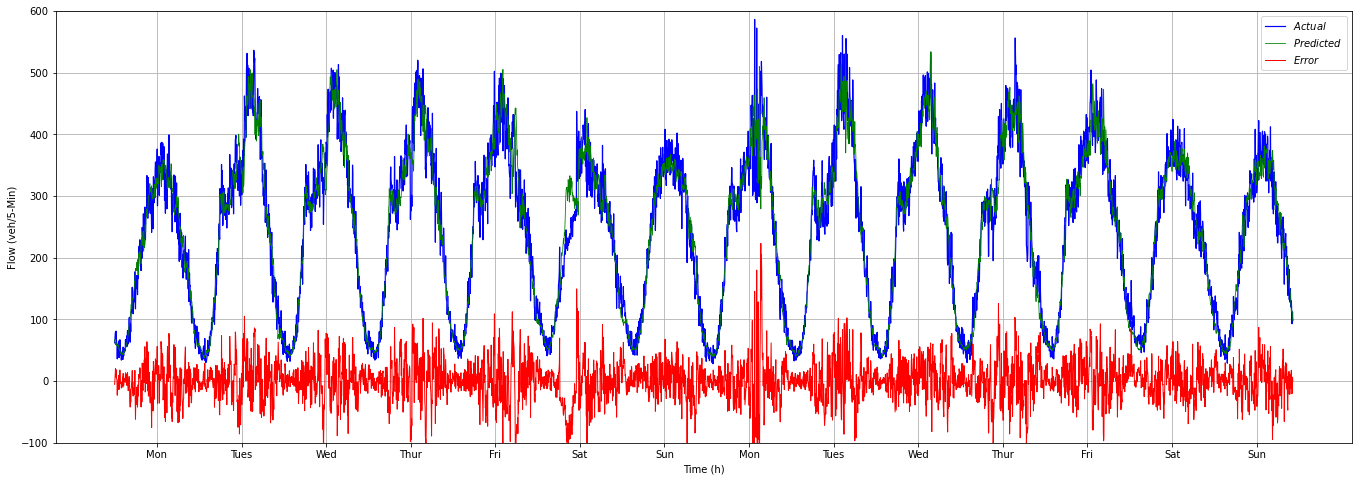

In [109]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv30, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions30, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv30-test_predictions30), lw=1, label=r'$Error$', color='red')

#axes.set_xlim(0,24)
axes.set_ylim(-100,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([144 + i for i in range(0, 4032, 288)])
axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

plt.show()

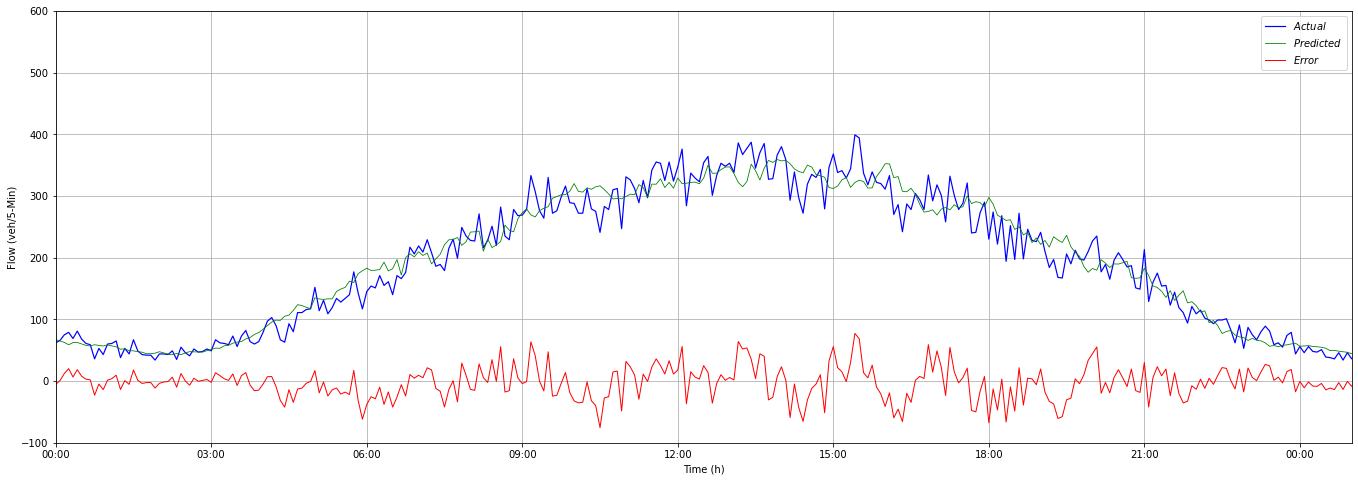

In [110]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv30, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions30, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv30-test_predictions30), lw=1, label=r'$Error$', color='red')

axes.set_xlim(0,300)
axes.set_ylim(-100,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

plt.show()

# 60 mins ahead

In [74]:
def build_model_60(hp):
    # Inputs
    channel_Deep = keras.layers.Input(shape=(None, n_steps, n_features, n_channels), name="DeepInput")
    
    # Deep Model
    # CNN 
    CNN_60 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_60 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_60)
    # LSTM          
    LSTM_60 = keras.layers.LSTM(units=hp.Int("units_LSTM", min_value=1, max_value=100, step=1), 
                                activation='relu')(flatten_60)
    
    # Output
    output = keras.layers.Dense(1, name= "output")(LSTM_60)
    
    # Model
    model_60 = keras.Model(inputs=[channel_Deep], outputs=[output])

    # Compile
    model_60.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss='mse',metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_60

In [75]:
tuner60 = RandomSearch(
    build_model_60,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=5,
    overwrite=False,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="7b-CNN-LSTM-60",
)

INFO:tensorflow:Reloading Oracle from existing project C:\RunsOak\7b-CNN-LSTM-60\oracle.json
INFO:tensorflow:Reloading Tuner from C:\RunsOak\7b-CNN-LSTM-60\tuner0.json


In [76]:
tuner60.search_space_summary()

Search space summary
Default search space size: 4
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
units_LSTM (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [77]:
tuner60.search((Xt60), yt60, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

INFO:tensorflow:Oracle triggered exit


In [78]:
tuner60.results_summary(1)

Results summary
Results in C:\RunsOak\7b-CNN-LSTM-60
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filters: 352
kernel_size: 2
units_LSTM: 63
learning_rate: 0.001
Score: 0.002730013756081462


### Best model

In [79]:
best_hp60 = tuner60.get_best_hyperparameters()[0]
model60 = tuner60.hypermodel.build(best_hp60)

In [80]:
scaler_filename = "Best_HP/7b-ConvLSTM-60"
joblib.dump(best_hp60, scaler_filename) 

['Best_HP/7b-ConvLSTM-60']

In [81]:
model60.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DeepInput (InputLayer)       [(None, None, 5, 6, 1)]   0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 4, 5, 352)   1760      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 7040)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 63)                1790208   
_________________________________________________________________
output (Dense)               (None, 1)                 64        
Total params: 1,792,032
Trainable params: 1,792,032
Non-trainable params: 0
_________________________________________________________________


In [82]:
# model60.fit(Xt60, yt60, 
#             epochs = 100, 
#             verbose = 0
#             )

In [83]:
# model60.save("my_dir/7b-CNN-LSTM-60")

In [84]:
# metrics60 = pd.DataFrame(model60.history.history)

In [85]:
# metrics60[['loss']].plot()

In [86]:
MSE60  = []
MAE60  = []
RMSE60 = []
MAPE60 = []

for i in range(100):
    print(f"run: {i+1}")
    model60.fit((Xt60), yt60, 
            epochs = 200, validation_split = val_percent,
            callbacks = [stop],
            verbose = 1
            )
    
    test_predictions60 = model60.predict((Xv60))

    yv60 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
    yv60 = yv60[26:,3]

    df = Test.drop(Test.head(26).index)
    df.reset_index(inplace = True)
    df = df.drop(columns=['index','Timestamp'])
    df['f4'] = pd.Series(test_predictions60.flatten())

    test_predictions60 = scaler.inverse_transform(df)

    test_predictions60 = test_predictions60[:,3]
    
    MSE60.append(mean_squared_error(yv60,test_predictions60))

    MAE60.append(mean_absolute_error(yv60,test_predictions60))

    RMSE60.append(np.sqrt(mean_squared_error(yv60,test_predictions60)))

    MAPE60.append(mean_absolute_percentage_error(yv60,test_predictions60)*100)


    current_mse = mean_squared_error(yv60,test_predictions60)
    if all(i > current_mse for i in MSE60):
        model60.save("my_dir/7b-CNN-LSTM-60")

eval60 = [mean(MSE60), mean(MAE60), mean(RMSE60), mean(MAPE60)]
std60 = [stdev(MSE60), stdev(MAE60), stdev(RMSE60), stdev(MAPE60)]
print(eval60)

run: 1
Epoch 1/200
1422/1422 [==============================] - 38s 26ms/step - loss: 0.0044 - mean_absolute_error: 0.0486 - root_mean_squared_error: 0.0665 - mean_absolute_percentage_error: 1068.2311 - val_loss: 0.0033 - val_mean_absolute_error: 0.0422 - val_root_mean_squared_error: 0.0578 - val_mean_absolute_percentage_error: 13.5031
Epoch 2/200
1422/1422 [==============================] - 37s 26ms/step - loss: 0.0035 - mean_absolute_error: 0.0433 - root_mean_squared_error: 0.0588 - mean_absolute_percentage_error: 1221.0709 - val_loss: 0.0033 - val_mean_absolute_error: 0.0420 - val_root_mean_squared_error: 0.0570 - val_mean_absolute_percentage_error: 14.4338
Epoch 3/200
1422/1422 [==============================] - 38s 26ms/step - loss: 0.0033 - mean_absolute_error: 0.0420 - root_mean_squared_error: 0.0570 - mean_absolute_percentage_error: 1395.2648 - val_loss: 0.0032 - val_mean_absolute_error: 0.0410 - val_root_mean_squared_error: 0.0568 - val_mean_absolute_percentage_error: 12.8633


run: 2
Epoch 1/200
1422/1422 [==============================] - 38s 26ms/step - loss: 0.0026 - mean_absolute_error: 0.0375 - root_mean_squared_error: 0.0512 - mean_absolute_percentage_error: 1525.6361 - val_loss: 0.0027 - val_mean_absolute_error: 0.0382 - val_root_mean_squared_error: 0.0523 - val_mean_absolute_percentage_error: 12.4709
Epoch 2/200
1422/1422 [==============================] - 37s 26ms/step - loss: 0.0026 - mean_absolute_error: 0.0373 - root_mean_squared_error: 0.0508 - mean_absolute_percentage_error: 1326.3098 - val_loss: 0.0028 - val_mean_absolute_error: 0.0387 - val_root_mean_squared_error: 0.0527 - val_mean_absolute_percentage_error: 13.1489
Epoch 3/200
1422/1422 [==============================] - 37s 26ms/step - loss: 0.0026 - mean_absolute_error: 0.0372 - root_mean_squared_error: 0.0507 - mean_absolute_percentage_error: 1403.9446 - val_loss: 0.0027 - val_mean_absolute_error: 0.0381 - val_root_mean_squared_error: 0.0523 - val_mean_absolute_percentage_error: 12.5371


Epoch 8/200
1422/1422 [==============================] - 37s 26ms/step - loss: 0.0023 - mean_absolute_error: 0.0355 - root_mean_squared_error: 0.0482 - mean_absolute_percentage_error: 1175.5460 - val_loss: 0.0029 - val_mean_absolute_error: 0.0398 - val_root_mean_squared_error: 0.0540 - val_mean_absolute_percentage_error: 12.7246
Epoch 9/200
1422/1422 [==============================] - 37s 26ms/step - loss: 0.0023 - mean_absolute_error: 0.0353 - root_mean_squared_error: 0.0480 - mean_absolute_percentage_error: 1420.0193 - val_loss: 0.0028 - val_mean_absolute_error: 0.0389 - val_root_mean_squared_error: 0.0534 - val_mean_absolute_percentage_error: 12.7912
Epoch 10/200
1422/1422 [==============================] - 37s 26ms/step - loss: 0.0023 - mean_absolute_error: 0.0352 - root_mean_squared_error: 0.0478 - mean_absolute_percentage_error: 1365.6688 - val_loss: 0.0028 - val_mean_absolute_error: 0.0387 - val_root_mean_squared_error: 0.0532 - val_mean_absolute_percentage_error: 12.4293
Epoch 

Epoch 10/200
1422/1422 [==============================] - 38s 27ms/step - loss: 0.0021 - mean_absolute_error: 0.0342 - root_mean_squared_error: 0.0463 - mean_absolute_percentage_error: 1247.7358 - val_loss: 0.0029 - val_mean_absolute_error: 0.0396 - val_root_mean_squared_error: 0.0537 - val_mean_absolute_percentage_error: 13.7430
Epoch 11/200
1422/1422 [==============================] - 38s 27ms/step - loss: 0.0021 - mean_absolute_error: 0.0341 - root_mean_squared_error: 0.0462 - mean_absolute_percentage_error: 1585.2527 - val_loss: 0.0029 - val_mean_absolute_error: 0.0392 - val_root_mean_squared_error: 0.0536 - val_mean_absolute_percentage_error: 13.6286
Epoch 12/200
1422/1422 [==============================] - 38s 27ms/step - loss: 0.0021 - mean_absolute_error: 0.0340 - root_mean_squared_error: 0.0461 - mean_absolute_percentage_error: 1137.7285 - val_loss: 0.0029 - val_mean_absolute_error: 0.0391 - val_root_mean_squared_error: 0.0535 - val_mean_absolute_percentage_error: 12.8118
Epoc

Epoch 8/200
1422/1422 [==============================] - 38s 27ms/step - loss: 0.0019 - mean_absolute_error: 0.0322 - root_mean_squared_error: 0.0434 - mean_absolute_percentage_error: 1351.5238 - val_loss: 0.0029 - val_mean_absolute_error: 0.0394 - val_root_mean_squared_error: 0.0534 - val_mean_absolute_percentage_error: 13.6179
Epoch 9/200
1422/1422 [==============================] - 38s 27ms/step - loss: 0.0019 - mean_absolute_error: 0.0320 - root_mean_squared_error: 0.0431 - mean_absolute_percentage_error: 1291.9919 - val_loss: 0.0029 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0542 - val_mean_absolute_percentage_error: 13.1736
run: 10
Epoch 1/200
1422/1422 [==============================] - 38s 27ms/step - loss: 0.0019 - mean_absolute_error: 0.0326 - root_mean_squared_error: 0.0440 - mean_absolute_percentage_error: 1261.9408 - val_loss: 0.0029 - val_mean_absolute_error: 0.0392 - val_root_mean_squared_error: 0.0538 - val_mean_absolute_percentage_error: 12.7226

run: 13
Epoch 1/200
1422/1422 [==============================] - 38s 27ms/step - loss: 0.0018 - mean_absolute_error: 0.0314 - root_mean_squared_error: 0.0422 - mean_absolute_percentage_error: 1546.2544 - val_loss: 0.0030 - val_mean_absolute_error: 0.0399 - val_root_mean_squared_error: 0.0548 - val_mean_absolute_percentage_error: 13.0473
Epoch 2/200
1422/1422 [==============================] - 38s 27ms/step - loss: 0.0018 - mean_absolute_error: 0.0313 - root_mean_squared_error: 0.0422 - mean_absolute_percentage_error: 1386.4155 - val_loss: 0.0030 - val_mean_absolute_error: 0.0400 - val_root_mean_squared_error: 0.0544 - val_mean_absolute_percentage_error: 13.4880
Epoch 3/200
1422/1422 [==============================] - 38s 27ms/step - loss: 0.0018 - mean_absolute_error: 0.0311 - root_mean_squared_error: 0.0419 - mean_absolute_percentage_error: 1219.0449 - val_loss: 0.0029 - val_mean_absolute_error: 0.0400 - val_root_mean_squared_error: 0.0541 - val_mean_absolute_percentage_error: 13.2794

Epoch 4/200
1422/1422 [==============================] - 37s 26ms/step - loss: 0.0016 - mean_absolute_error: 0.0301 - root_mean_squared_error: 0.0405 - mean_absolute_percentage_error: 1521.1672 - val_loss: 0.0031 - val_mean_absolute_error: 0.0404 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_percentage_error: 12.9738
Epoch 5/200
1422/1422 [==============================] - 37s 26ms/step - loss: 0.0016 - mean_absolute_error: 0.0300 - root_mean_squared_error: 0.0402 - mean_absolute_percentage_error: 1413.8511 - val_loss: 0.0031 - val_mean_absolute_error: 0.0407 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_percentage_error: 13.2549
Epoch 6/200
1422/1422 [==============================] - 37s 26ms/step - loss: 0.0016 - mean_absolute_error: 0.0299 - root_mean_squared_error: 0.0400 - mean_absolute_percentage_error: 1417.3373 - val_loss: 0.0031 - val_mean_absolute_error: 0.0406 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_percentage_error: 12.9466
run: 17

1422/1422 [==============================] - 39s 27ms/step - loss: 0.0014 - mean_absolute_error: 0.0284 - root_mean_squared_error: 0.0379 - mean_absolute_percentage_error: 1286.0510 - val_loss: 0.0032 - val_mean_absolute_error: 0.0412 - val_root_mean_squared_error: 0.0568 - val_mean_absolute_percentage_error: 13.2588
Epoch 2/200
1422/1422 [==============================] - 39s 27ms/step - loss: 0.0014 - mean_absolute_error: 0.0282 - root_mean_squared_error: 0.0377 - mean_absolute_percentage_error: 1658.5946 - val_loss: 0.0032 - val_mean_absolute_error: 0.0408 - val_root_mean_squared_error: 0.0562 - val_mean_absolute_percentage_error: 13.2127
Epoch 3/200
1422/1422 [==============================] - 39s 27ms/step - loss: 0.0014 - mean_absolute_error: 0.0281 - root_mean_squared_error: 0.0375 - mean_absolute_percentage_error: 1275.6390 - val_loss: 0.0032 - val_mean_absolute_error: 0.0412 - val_root_mean_squared_error: 0.0569 - val_mean_absolute_percentage_error: 13.2770
Epoch 4/200
1422/14

Epoch 2/200
1422/1422 [==============================] - 38s 27ms/step - loss: 0.0012 - mean_absolute_error: 0.0266 - root_mean_squared_error: 0.0353 - mean_absolute_percentage_error: 1377.7736 - val_loss: 0.0034 - val_mean_absolute_error: 0.0425 - val_root_mean_squared_error: 0.0583 - val_mean_absolute_percentage_error: 13.5878
Epoch 3/200
1422/1422 [==============================] - 38s 27ms/step - loss: 0.0012 - mean_absolute_error: 0.0264 - root_mean_squared_error: 0.0351 - mean_absolute_percentage_error: 1265.4612 - val_loss: 0.0033 - val_mean_absolute_error: 0.0418 - val_root_mean_squared_error: 0.0572 - val_mean_absolute_percentage_error: 13.6291
Epoch 4/200
1422/1422 [==============================] - 38s 27ms/step - loss: 0.0012 - mean_absolute_error: 0.0262 - root_mean_squared_error: 0.0349 - mean_absolute_percentage_error: 1296.6172 - val_loss: 0.0034 - val_mean_absolute_error: 0.0424 - val_root_mean_squared_error: 0.0579 - val_mean_absolute_percentage_error: 13.3710
Epoch 5

Epoch 8/200
1422/1422 [==============================] - 38s 26ms/step - loss: 9.8144e-04 - mean_absolute_error: 0.0238 - root_mean_squared_error: 0.0313 - mean_absolute_percentage_error: 1348.8872 - val_loss: 0.0037 - val_mean_absolute_error: 0.0444 - val_root_mean_squared_error: 0.0610 - val_mean_absolute_percentage_error: 14.5139
Epoch 9/200
1422/1422 [==============================] - 37s 26ms/step - loss: 9.8050e-04 - mean_absolute_error: 0.0237 - root_mean_squared_error: 0.0313 - mean_absolute_percentage_error: 1480.8514 - val_loss: 0.0036 - val_mean_absolute_error: 0.0437 - val_root_mean_squared_error: 0.0600 - val_mean_absolute_percentage_error: 14.1541
run: 36
Epoch 1/200
1422/1422 [==============================] - 38s 27ms/step - loss: 0.0010 - mean_absolute_error: 0.0242 - root_mean_squared_error: 0.0319 - mean_absolute_percentage_error: 1458.6866 - val_loss: 0.0036 - val_mean_absolute_error: 0.0437 - val_root_mean_squared_error: 0.0603 - val_mean_absolute_percentage_error:

1422/1422 [==============================] - 37s 26ms/step - loss: 8.2901e-04 - mean_absolute_error: 0.0219 - root_mean_squared_error: 0.0288 - mean_absolute_percentage_error: 1449.6653 - val_loss: 0.0039 - val_mean_absolute_error: 0.0448 - val_root_mean_squared_error: 0.0621 - val_mean_absolute_percentage_error: 14.4165
run: 42
Epoch 1/200
1422/1422 [==============================] - 38s 27ms/step - loss: 8.5848e-04 - mean_absolute_error: 0.0223 - root_mean_squared_error: 0.0293 - mean_absolute_percentage_error: 1314.0468 - val_loss: 0.0039 - val_mean_absolute_error: 0.0450 - val_root_mean_squared_error: 0.0622 - val_mean_absolute_percentage_error: 14.0152
Epoch 2/200
1422/1422 [==============================] - 38s 27ms/step - loss: 8.6142e-04 - mean_absolute_error: 0.0224 - root_mean_squared_error: 0.0293 - mean_absolute_percentage_error: 1348.9500 - val_loss: 0.0038 - val_mean_absolute_error: 0.0447 - val_root_mean_squared_error: 0.0618 - val_mean_absolute_percentage_error: 14.1667

1422/1422 [==============================] - 38s 27ms/step - loss: 7.4000e-04 - mean_absolute_error: 0.0208 - root_mean_squared_error: 0.0272 - mean_absolute_percentage_error: 1371.2228 - val_loss: 0.0040 - val_mean_absolute_error: 0.0458 - val_root_mean_squared_error: 0.0631 - val_mean_absolute_percentage_error: 14.2563
Epoch 6/200
1422/1422 [==============================] - 38s 27ms/step - loss: 7.3028e-04 - mean_absolute_error: 0.0207 - root_mean_squared_error: 0.0270 - mean_absolute_percentage_error: 1525.4801 - val_loss: 0.0040 - val_mean_absolute_error: 0.0458 - val_root_mean_squared_error: 0.0633 - val_mean_absolute_percentage_error: 14.7053
Epoch 7/200
1422/1422 [==============================] - 38s 27ms/step - loss: 7.2315e-04 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0269 - mean_absolute_percentage_error: 1412.0767 - val_loss: 0.0040 - val_mean_absolute_error: 0.0455 - val_root_mean_squared_error: 0.0635 - val_mean_absolute_percentage_error: 14.2087
Epoch 8

1422/1422 [==============================] - 38s 27ms/step - loss: 6.0939e-04 - mean_absolute_error: 0.0189 - root_mean_squared_error: 0.0247 - mean_absolute_percentage_error: 1494.2439 - val_loss: 0.0043 - val_mean_absolute_error: 0.0471 - val_root_mean_squared_error: 0.0654 - val_mean_absolute_percentage_error: 15.3418
Epoch 10/200
1422/1422 [==============================] - 38s 27ms/step - loss: 6.1131e-04 - mean_absolute_error: 0.0190 - root_mean_squared_error: 0.0247 - mean_absolute_percentage_error: 1264.7505 - val_loss: 0.0042 - val_mean_absolute_error: 0.0470 - val_root_mean_squared_error: 0.0651 - val_mean_absolute_percentage_error: 15.0968
run: 54
Epoch 1/200
1422/1422 [==============================] - 38s 27ms/step - loss: 6.2970e-04 - mean_absolute_error: 0.0192 - root_mean_squared_error: 0.0251 - mean_absolute_percentage_error: 1282.3635 - val_loss: 0.0042 - val_mean_absolute_error: 0.0469 - val_root_mean_squared_error: 0.0651 - val_mean_absolute_percentage_error: 14.748

1422/1422 [==============================] - 37s 26ms/step - loss: 5.4324e-04 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0233 - mean_absolute_percentage_error: 1430.6329 - val_loss: 0.0043 - val_mean_absolute_error: 0.0473 - val_root_mean_squared_error: 0.0658 - val_mean_absolute_percentage_error: 15.1236
Epoch 6/200
1422/1422 [==============================] - 37s 26ms/step - loss: 5.3276e-04 - mean_absolute_error: 0.0177 - root_mean_squared_error: 0.0231 - mean_absolute_percentage_error: 1314.5685 - val_loss: 0.0044 - val_mean_absolute_error: 0.0478 - val_root_mean_squared_error: 0.0664 - val_mean_absolute_percentage_error: 14.9988
Epoch 7/200
1422/1422 [==============================] - 37s 26ms/step - loss: 5.3039e-04 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0230 - mean_absolute_percentage_error: 1441.2468 - val_loss: 0.0044 - val_mean_absolute_error: 0.0475 - val_root_mean_squared_error: 0.0662 - val_mean_absolute_percentage_error: 15.0519
Epoch 8

1422/1422 [==============================] - 38s 27ms/step - loss: 4.6610e-04 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0216 - mean_absolute_percentage_error: 1298.1860 - val_loss: 0.0045 - val_mean_absolute_error: 0.0482 - val_root_mean_squared_error: 0.0673 - val_mean_absolute_percentage_error: 15.3169- loss: 4.6407e-04 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0215 - mea
run: 65
Epoch 1/200
1422/1422 [==============================] - 38s 27ms/step - loss: 4.8473e-04 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0220 - mean_absolute_percentage_error: 1196.3463 - val_loss: 0.0044 - val_mean_absolute_error: 0.0478 - val_root_mean_squared_error: 0.0664 - val_mean_absolute_percentage_error: 14.7898
Epoch 2/200
1422/1422 [==============================] - 38s 27ms/step - loss: 4.7612e-04 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0218 - mean_absolute_percentage_error: 1357.6967 - val_loss: 0.0044 - val_mean_absolute_error: 0.

1422/1422 [==============================] - 38s 27ms/step - loss: 4.1625e-04 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0204 - mean_absolute_percentage_error: 1318.8547 - val_loss: 0.0045 - val_mean_absolute_error: 0.0483 - val_root_mean_squared_error: 0.0673 - val_mean_absolute_percentage_error: 15.0833
Epoch 2/200
1422/1422 [==============================] - 38s 27ms/step - loss: 4.2009e-04 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0205 - mean_absolute_percentage_error: 1268.1343 - val_loss: 0.0046 - val_mean_absolute_error: 0.0487 - val_root_mean_squared_error: 0.0678 - val_mean_absolute_percentage_error: 15.3957
Epoch 3/200
1422/1422 [==============================] - 38s 27ms/step - loss: 4.1016e-04 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0203 - mean_absolute_percentage_error: 1317.1381 - val_loss: 0.0046 - val_mean_absolute_error: 0.0487 - val_root_mean_squared_error: 0.0676 - val_mean_absolute_percentage_error: 15.1329
Epoch 4

1422/1422 [==============================] - 38s 27ms/step - loss: 3.9018e-04 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0198 - mean_absolute_percentage_error: 1375.2555 - val_loss: 0.0046 - val_mean_absolute_error: 0.0488 - val_root_mean_squared_error: 0.0680 - val_mean_absolute_percentage_error: 15.3902
run: 73
Epoch 1/200
1422/1422 [==============================] - 38s 27ms/step - loss: 4.0787e-04 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0202 - mean_absolute_percentage_error: 1496.8584 - val_loss: 0.0046 - val_mean_absolute_error: 0.0486 - val_root_mean_squared_error: 0.0678 - val_mean_absolute_percentage_error: 15.1788
Epoch 2/200
1422/1422 [==============================] - 38s 27ms/step - loss: 3.9603e-04 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0199 - mean_absolute_percentage_error: 1257.7584 - val_loss: 0.0046 - val_mean_absolute_error: 0.0486 - val_root_mean_squared_error: 0.0679 - val_mean_absolute_percentage_error: 15.1173

1422/1422 [==============================] - 38s 26ms/step - loss: 3.5917e-04 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0190 - mean_absolute_percentage_error: 1376.8143 - val_loss: 0.0046 - val_mean_absolute_error: 0.0490 - val_root_mean_squared_error: 0.0679 - val_mean_absolute_percentage_error: 15.7266
Epoch 5/200
1422/1422 [==============================] - 38s 26ms/step - loss: 3.5183e-04 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0188 - mean_absolute_percentage_error: 1402.6466 - val_loss: 0.0047 - val_mean_absolute_error: 0.0490 - val_root_mean_squared_error: 0.0682 - val_mean_absolute_percentage_error: 15.4765
Epoch 6/200
1422/1422 [==============================] - 38s 26ms/step - loss: 3.6018e-04 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0190 - mean_absolute_percentage_error: 1431.1178 - val_loss: 0.0045 - val_mean_absolute_error: 0.0481 - val_root_mean_squared_error: 0.0669 - val_mean_absolute_percentage_error: 15.1122
Epoch 7

1422/1422 [==============================] - 38s 27ms/step - loss: 3.3038e-04 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0182 - mean_absolute_percentage_error: 1410.5571 - val_loss: 0.0046 - val_mean_absolute_error: 0.0488 - val_root_mean_squared_error: 0.0680 - val_mean_absolute_percentage_error: 15.3387
Epoch 3/200
1422/1422 [==============================] - 38s 27ms/step - loss: 3.3836e-04 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0184 - mean_absolute_percentage_error: 1474.4087 - val_loss: 0.0047 - val_mean_absolute_error: 0.0494 - val_root_mean_squared_error: 0.0688 - val_mean_absolute_percentage_error: 16.1189
Epoch 4/200
1422/1422 [==============================] - 38s 26ms/step - loss: 3.3123e-04 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0182 - mean_absolute_percentage_error: 1156.5448 - val_loss: 0.0048 - val_mean_absolute_error: 0.0494 - val_root_mean_squared_error: 0.0690 - val_mean_absolute_percentage_error: 15.3366
Epoch 5

1422/1422 [==============================] - 38s 27ms/step - loss: 3.1849e-04 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0178 - mean_absolute_percentage_error: 1546.9523 - val_loss: 0.0047 - val_mean_absolute_error: 0.0491 - val_root_mean_squared_error: 0.0686 - val_mean_absolute_percentage_error: 15.3946
Epoch 2/200
1422/1422 [==============================] - 38s 27ms/step - loss: 3.1968e-04 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0179 - mean_absolute_percentage_error: 1475.5652 - val_loss: 0.0048 - val_mean_absolute_error: 0.0495 - val_root_mean_squared_error: 0.0689 - val_mean_absolute_percentage_error: 15.4569
Epoch 3/200
1422/1422 [==============================] - 38s 27ms/step - loss: 3.1006e-04 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0176 - mean_absolute_percentage_error: 1357.0818 - val_loss: 0.0047 - val_mean_absolute_error: 0.0492 - val_root_mean_squared_error: 0.0685 - val_mean_absolute_percentage_error: 15.9657
Epoch 4

Epoch 3/200
1422/1422 [==============================] - 38s 27ms/step - loss: 2.9746e-04 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0172 - mean_absolute_percentage_error: 1348.5543 - val_loss: 0.0048 - val_mean_absolute_error: 0.0498 - val_root_mean_squared_error: 0.0695 - val_mean_absolute_percentage_error: 15.4680
Epoch 4/200
1422/1422 [==============================] - 38s 27ms/step - loss: 2.9819e-04 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0173 - mean_absolute_percentage_error: 1194.1978 - val_loss: 0.0048 - val_mean_absolute_error: 0.0497 - val_root_mean_squared_error: 0.0690 - val_mean_absolute_percentage_error: 15.6077
Epoch 5/200
1422/1422 [==============================] - 38s 27ms/step - loss: 2.9268e-04 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0171 - mean_absolute_percentage_error: 1286.5461 - val_loss: 0.0048 - val_mean_absolute_error: 0.0500 - val_root_mean_squared_error: 0.0694 - val_mean_absolute_percentage_error: 16.

1422/1422 [==============================] - 38s 27ms/step - loss: 2.7468e-04 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0166 - mean_absolute_percentage_error: 1506.4038 - val_loss: 0.0049 - val_mean_absolute_error: 0.0502 - val_root_mean_squared_error: 0.0697 - val_mean_absolute_percentage_error: 15.6214.7237e-04 - mean_absolute_error:
Epoch 6/200
1422/1422 [==============================] - 38s 27ms/step - loss: 2.8082e-04 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0168 - mean_absolute_percentage_error: 1255.2609 - val_loss: 0.0047 - val_mean_absolute_error: 0.0496 - val_root_mean_squared_error: 0.0689 - val_mean_absolute_percentage_error: 15.8187
Epoch 7/200
1422/1422 [==============================] - 38s 27ms/step - loss: 2.6998e-04 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0164 - mean_absolute_percentage_error: 1433.3326 - val_loss: 0.0048 - val_mean_absolute_error: 0.0496 - val_root_mean_squared_error: 0.0692 - val_mean_absolute_p

In [87]:
model60 = keras.models.load_model("my_dir/7b-CNN-LSTM-60")

In [111]:
runs = {'MSE': MSE60, 'MAE': MAE60, 'RMSE': RMSE60, 'MAPE': MAPE60}
table60 = pd.DataFrame(data=runs)
table60.to_csv("Results/Runs/7b-CNN-LSTM-60")

In [112]:
pd.read_csv("Results/Runs/7b-CNN-LSTM-60", index_col=0)

,MSE,MAE,RMSE,MAPE
0,1271.256135,25.602793,35.654679,12.176754
1,1235.275303,25.451876,35.146484,12.084912
2,1248.505984,25.571619,35.334204,12.589863
3,1243.058756,25.519349,35.257038,12.274210
4,1292.637554,25.943015,35.953269,12.356123
...,...,...,...,...
95,2026.031620,31.757913,45.011461,14.248920
96,2077.687637,31.985849,45.581659,14.337832
97,2080.714991,32.041582,45.614855,14.468500
98,2129.957234,32.530901,46.151460,14.611938


### Evaluation on inverse_transform

In [88]:
test_predictions60 = model60.predict((Xv60))

yv60 = scaler.inverse_transform(Test.drop('Timestamp', axis = 1))
yv60 = yv60[26:,3]

df = Test.drop(Test.head(26).index)
df.reset_index(inplace = True)
df = df.drop(columns=['index','Timestamp'])
df['f4'] = pd.Series(test_predictions60.flatten())

test_predictions60 = scaler.inverse_transform(df)

test_predictions60 = test_predictions60[:,3]

# MSE60 = mean_squared_error(yv60,test_predictions60)

# MAE60 = mean_absolute_error(yv60,test_predictions60)

# RMSE60 = np.sqrt(MSE60)

# MAPE60 = mean_absolute_percentage_error(yv60,test_predictions60)*100

# eval60 = [MSE60, MAE60, RMSE60, MAPE60]
# print(eval60)

In [89]:
RA10 = ra.RA_10(np.asarray(yv60), np.asarray(test_predictions60))
RA15 = ra.RA_15(np.asarray(yv60), np.asarray(test_predictions60))
RA20 = ra.RA_20(np.asarray(yv60), np.asarray(test_predictions60))

res60 = [RA10, RA15, RA20]
print(res60)

[48.65202196704942, 66.1258112830754, 78.55716425361958]


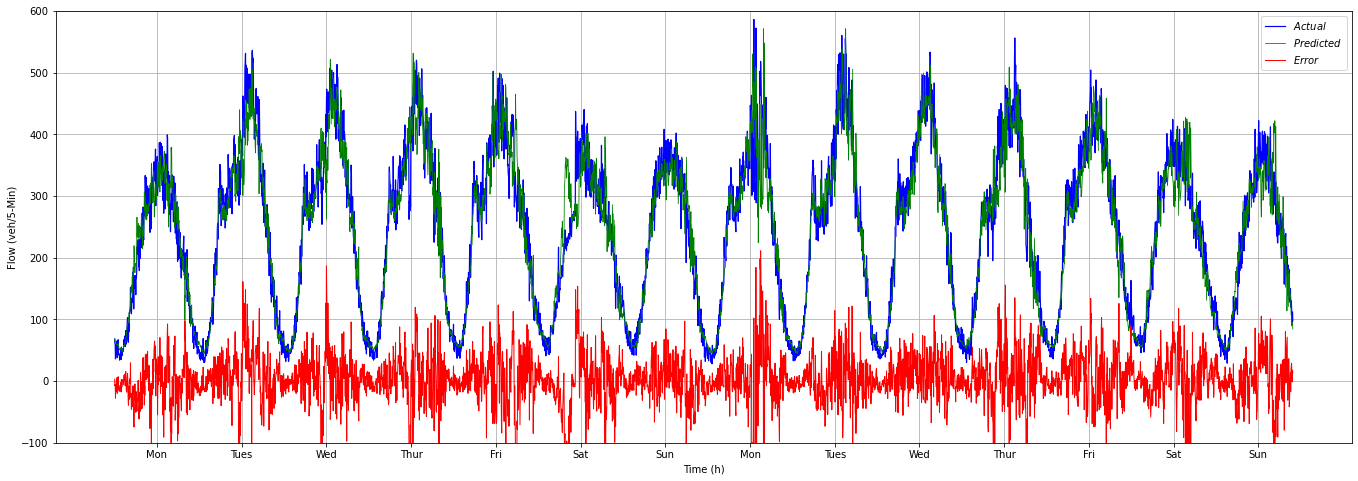

In [90]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv60, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions60, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv60-test_predictions60), lw=1, label=r'$Error$', color='red')

#axes.set_xlim(0,24)
axes.set_ylim(-100,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([144 + i for i in range(0, 4032, 288)])
axes.set_xticklabels(['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']*2)

plt.show()

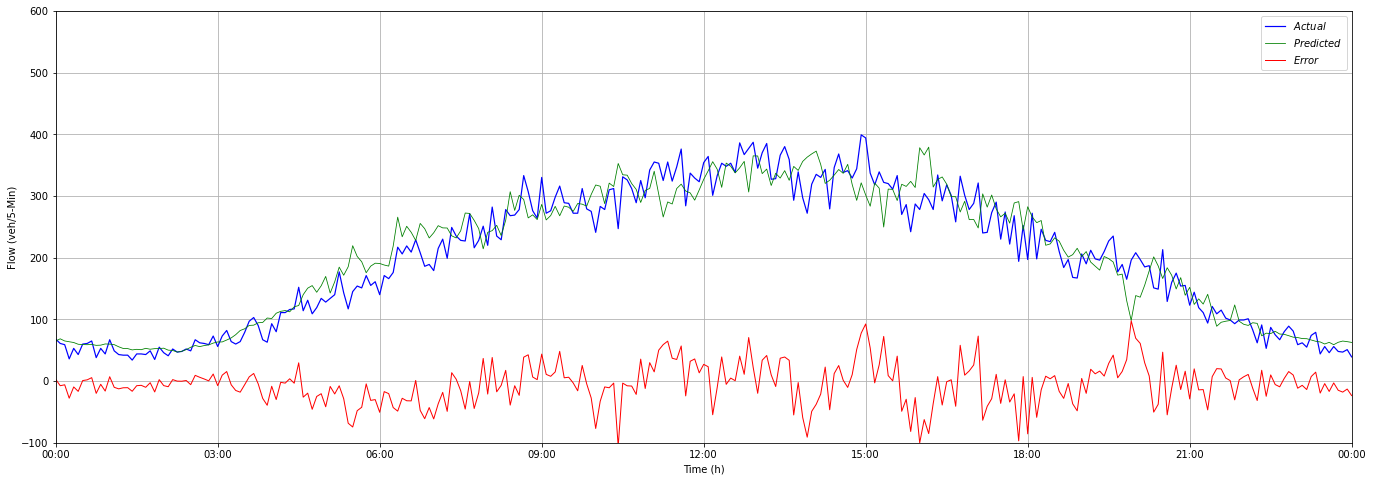

In [91]:
# Create Figure (empty canvas)
fig = plt.figure(figsize=(18,6))

# Add set of axes to figure
axes = fig.add_axes([0, 0, 1, 1]) # left, bottom, width, height (range 0 to 1)

# Plot on that set of axes
axes.plot(yv60, lw=1.2, label=r'$Actual$', color='blue')
axes.plot(test_predictions60, lw=0.8, label=r'$Predicted$', color='green')
axes.plot((yv60-test_predictions60), lw=1, label=r'$Error$', color='red')

axes.set_xlim(0,24)
axes.set_ylim(-100,600)
axes.set_xlabel('Time (h)')
axes.set_ylabel('Flow (veh/5-Min)')

axes.legend(loc=1)
axes.grid()

axes.set_xticks([0, 36, 72, 108, 144, 180, 216, 252, 288])
axes.set_xticklabels(['00:00', '03:00', '06:00', '09:00', '12:00', '15:00', '18:00', '21:00','00:00'])

plt.show()

# RESULTS

## General results

In [92]:
l = ['MSE','MAE','RMSE','MAPE','Horizon']

In [93]:
eval5.append(5)
eval15.append(15)
eval30.append(30)
eval60.append(60)

In [94]:
df = pd.DataFrame(np.array([eval5,eval15,eval30,eval60]),columns=l)
df.set_index('Horizon')

,MSE,MAE,RMSE,MAPE
Horizon,,,,
5.0,971.928518,22.569230,31.026625,11.062605
15.0,1248.915671,25.428523,35.343587,12.170343
30.0,1295.532853,25.862613,35.874847,12.289418
60.0,1771.618871,29.598309,41.936922,13.575951


## Relative accuracy

In [95]:
m = ['10%','15%','20%','Horizon']

In [96]:
res5.append(5)
res15.append(15)
res30.append(30)
res60.append(60)

In [114]:
df1 = pd.DataFrame(np.array([res5,res15,res30,res60]),columns=m)
df1.set_index('Horizon')

,10%,15%,20%
Horizon,,,
5.0,57.306448,74.707493,85.710729
15.0,57.135741,75.915318,85.554172
30.0,53.938185,72.158524,83.599202
60.0,48.652022,66.125811,78.557164


## Save

In [98]:
x = np.array([eval5, eval15, eval30, eval60])
y = np.array([std5, std15, std30, std60])

In [99]:
np.savez("Results/7a", x=x , y=y)